<a href="https://colab.research.google.com/github/halimcan/Home-Credit-Default-Project/blob/Catboost%2C-LightGBM%2C-XGBoost%2C-Blending%2C-Stacking(Logistic-Regression-Meta-Model)_branch10/aggregated_master_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd

import gc
# Imports the garbage collection module to manually free unused memory.

import os
# Imports the OS module to work with file paths and the file system.

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"
# Base directory path where all aggregated Home Credit tables are stored.



# Converting csv based tables into parquet

In [3]:
import polars as pl
# Imports the Polars library, a high-performance DataFrame engine optimized for speed and memory efficiency.

import os
# Imports the OS module to interact with the file system (list directories, join paths, etc.).

for file in os.listdir(BASE):
    # Iterates through all files located in the BASE directory.

    if file.endswith(".csv"):
        # Processes only files with the .csv extension.

        csv_path = f"{BASE}/{file}"
        # Builds the full path to the current CSV file.

        pq_path = csv_path.replace(".csv", ".parquet")
        # Defines the output path by replacing the .csv extension with .parquet.

        print(f"→ Converting: {file}  -->  {pq_path}")
        # Prints a progress message indicating which file is being converted.

        df = pl.read_csv(csv_path)
        # Loads the CSV file into a Polars DataFrame.

        df.write_parquet(pq_path)
        # Writes the DataFrame to disk in Parquet format.


→ Converting: application_train.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/application_train.parquet
→ Converting: bureau.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/bureau.parquet
→ Converting: application_test.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/application_test.parquet
→ Converting: bureau_agg.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/bureau_agg.parquet
→ Converting: pos_agg.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/pos_agg.parquet
→ Converting: installments_agg.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/installments_agg.parquet
→ Converting: cc_agg.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/cc_agg.parquet
→ Converting: previous_agg.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/previous_agg.parquet
→ Converting: bureau_bal_loan.csv  -->  /content/drive/MyDrive/HomeCredit/Aggregated_tables/bureau_bal_loan.parquet
→ Converting: su

# Merging bureau and bureau loan tables through polars, and some additional aggregations with numerical variables(mean,max etc.)

In [4]:
import polars as pl
# Imports the Polars library for high-performance DataFrame processing.

import polars.selectors as cs
# Imports column selectors to easily filter numeric, string, or boolean columns.

# Raw datas
bureau = pl.read_csv(f"{BASE}/bureau.csv")
# Loads the raw bureau table containing historical credit information for each loan.

balance = pl.read_csv(f"{BASE}/bureau_bal_loan.csv")
# Loads the bureau balance table containing monthly status records for each bureau loan.

# SK_ID_CURR add
bb = balance.join(
    bureau.select(["SK_ID_BUREAU", "SK_ID_CURR"]),
    # Selects only the keys needed for joining (bureau loan ID → customer ID).

    on="SK_ID_BUREAU",
    # Performs the join based on the bureau loan identifier.

    how="left"
    # Uses a left join to ensure all balance records remain even if bureau data is missing.
)
# This join attaches SK_ID_CURR (customer ID) to each row of the bureau balance table.

# Selecting numerical columns
numeric_cols = bb.select(cs.numeric()).columns
# Extracts the names of all numeric columns to automatically generate aggregated features.

# Aggregation list
agg_exprs = []
# Initializes an empty list that will store Polars aggregation expressions.

for col in numeric_cols:
    # Iterates over every numerical column to generate aggregation metrics.

    agg_exprs.extend([
        pl.col(col).mean().alias(f"{col}_MEAN"),
        # Computes the mean value per customer for this column.

        pl.col(col).min().alias(f"{col}_MIN"),
        # Computes the minimum value per customer.

        pl.col(col).max().alias(f"{col}_MAX"),
        # Computes the maximum value per customer.

        pl.col(col).sum().alias(f"{col}_SUM")
        # Computes the total sum per customer.
    ])
# After the loop, agg_exprs contains all aggregated feature expressions for numeric columns.

# SK_ID_CURR aggregation
bb_agg_curr = (
    bb.group_by("SK_ID_CURR")
      # Groups monthly bureau balance records by customer ID.

      .agg(agg_exprs + [pl.len().alias("BB_COUNT")])
      # Computes all aggregated numerical features plus a count of records per customer.
)
# The result is one row per SK_ID_CURR containing aggregated bureau balance features.

# Save as parquet
bb_agg_curr.write_parquet(f"{BASE}/bureau_bal_loan.parquet")
# Saves the aggregated dataset in Parquet format for fast loading in downstream modeling.





# Lazy Frame based ETL of the aggregated tables

In [5]:
train = pl.scan_parquet(f"{BASE}/application_train.parquet")
# Lazily loads the main application table (one row per current loan application).
# Using `scan_parquet` enables lazy execution, avoiding full data loading until `collect()` is called.

bureau_agg = pl.scan_parquet(f"{BASE}/bureau_agg.parquet")
# Loads aggregated external credit bureau data (historical loans from external institutions),
# represented at the customer (SK_ID_CURR) level.

previous_agg = pl.scan_parquet(f"{BASE}/previous_agg.parquet")
# Loads aggregated information from previous credit applications,
# providing historical behavior insights for each customer.

pos_agg = pl.scan_parquet(f"{BASE}/pos_agg.parquet")
# Loads aggregated POS (point of sale) and cash loan data,
# containing monthly and installment-based behavior patterns.

installments_agg = pl.scan_parquet(f"{BASE}/installments_agg.parquet")
# Loads aggregated installments payment history (e.g., payment delays, missed payments),
# which is highly predictive for credit risk.

cc_agg = pl.scan_parquet(f"{BASE}/cc_agg.parquet")
# Loads aggregated credit card balance and payment information,
# capturing revolving credit behavior and utilization ratios.

bureau_bal_loan = pl.scan_parquet(f"{BASE}/bureau_bal_loan.parquet")
# Loads aggregated monthly bureau balance data for external loans,
# including derived metrics such as mean, min, max, and counts for each customer.



# Merging all parquet tables.

In [6]:
train_merged = (
    train
    # Starts with the main application_train LazyFrame, representing the primary loan applications.

    .join(bureau_agg, on="SK_ID_CURR", how="left", suffix="_bur")
    # Merges aggregated external bureau information.
    # LEFT JOIN ensures that every application remains in the dataset even if some customers
    # do not have bureau history.
    # `suffix="_bur"` prevents column name collisions.

    .join(bureau_bal_loan, on="SK_ID_CURR", how="left", suffix="_bal")
    # Adds aggregated monthly bureau balance results (e.g., mean, max, min values for bureau loans).
    # These features often capture delinquency patterns and credit behavior over time.

    .join(previous_agg, on="SK_ID_CURR", how="left", suffix="_prev")
    # Adds aggregated results from previous loan applications.
    # Includes approval rates, refused applications, and other historical application behaviors.

    .join(pos_agg, on="SK_ID_CURR", how="left", suffix="_pos")
    # Adds POS (point-of-sale) and cash loan aggregated features.
    # Captures trends of monthly status, delays, late payments, and consumer finance behavior.

    .join(installments_agg, on="SK_ID_CURR", how="left", suffix="_ins")
    # Adds aggregated installment payments—one of the strongest predictors for credit default.
    # Includes late payment metrics, missed installments, and repayment patterns.

    .join(cc_agg, on="SK_ID_CURR", how="left", suffix="_cc")
    # Adds aggregated credit card balance and payment features.
    # These features capture revolving credit utilization, minimum payments, and delinquency indicators.
)
# The resulting LazyFrame contains all engineered features merged into a single dataset.
# Because this is LazyFrame-based, Polars will optimize the entire join chain before execution.


In [7]:
train_final = train_merged.collect()
# Executes the entire lazy computation graph and loads the fully merged dataset into memory.
# This triggers:
#   - all deferred joins,
#   - predicate and projection pushdowns,
#   - query optimization,
#   - and final materialization of the full feature matrix.
# The result is a concrete Polars DataFrame containing all engineered and merged features.




In [8]:
train_final.write_parquet(f"{BASE}/train_full.parquet")
# Writes the fully merged and materialized training dataset to disk in Parquet format.
# Parquet is a columnar, compressed, high-performance file format ideal for ML pipelines,
# enabling faster loading, lower disk usage, and efficient column-level access.
# This file will serve as the final feature matrix used in model training.


In [9]:
train_final.shape


(307511, 567)

In [11]:
train_final.group_by("SK_ID_CURR").count().sort("count", descending=True).head(20)  # Current application’s customer ID
# Groups the final dataset by SK_ID_CURR to check for duplicate customer IDs.
# `.count()` computes the number of rows associated with each customer.
# `.sort("count", descending=True)` ranks customers by row count in descending order.
# `.head(20)` displays the top 20 customers with the highest number of duplicate records.
# This is a validation step to ensure that the final dataset respects the one-row-per-customer structure.



/tmp/ipython-input-4043467591.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  train_final.group_by("SK_ID_CURR").count().sort("count", descending=True).head(20)  # Current application’s customer ID


SK_ID_CURR,count
i64,u32
137683,1
403024,1
414528,1
448080,1
366020,1
…,…
221285,1
314739,1
260799,1


In [10]:
dup_check = (
    train_final
        .group_by("SK_ID_CURR")
        .count()
        .filter(pl.col("count") > 1)
)

dup_check
# Returns all customers that appear more than once in the final dataset.


/tmp/ipython-input-255606725.py:4: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


SK_ID_CURR,count
i64,u32


No customer has more than one row.
Dataset is perfectly aggregated.
train_final contains exactly one row per SK_ID_CURR.

# Test_application merge

In [12]:
import polars as pl


# ---------------------------------------------
# 1) Parquet dosyalarını load et
# ---------------------------------------------
test  = pl.scan_parquet(f"{BASE}/application_test.parquet")

bureau_agg       = pl.scan_parquet(f"{BASE}/bureau_agg.parquet")
previous_agg     = pl.scan_parquet(f"{BASE}/previous_agg.parquet")
pos_agg          = pl.scan_parquet(f"{BASE}/pos_agg.parquet")
installments_agg = pl.scan_parquet(f"{BASE}/installments_agg.parquet")
cc_agg           = pl.scan_parquet(f"{BASE}/cc_agg.parquet")
bureau_bal_loan  = pl.scan_parquet(f"{BASE}/bureau_bal_loan.parquet")  # aggregation already done


# ---------------------------------------------
# 2) TEST JOIN PIPELINE  (train ile birebir aynı sıralama)
# ---------------------------------------------
test_merged = (
    test
    .join(bureau_agg,        on="SK_ID_CURR", how="left", suffix="_bur")
    .join(bureau_bal_loan,   on="SK_ID_CURR", how="left", suffix="_bal")
    .join(previous_agg,      on="SK_ID_CURR", how="left", suffix="_prev")
    .join(pos_agg,           on="SK_ID_CURR", how="left", suffix="_pos")
    .join(installments_agg,  on="SK_ID_CURR", how="left", suffix="_ins")
    .join(cc_agg,            on="SK_ID_CURR", how="left", suffix="_cc")
)

# ---------------------------------------------
# 3) Final test dataframe
# ---------------------------------------------
test_final = test_merged.collect()
test_final.write_parquet(f"{BASE}/test_full.parquet")

# Sonuç
print("TEST FINAL SHAPE:", test_final.shape)


TEST FINAL SHAPE: (48744, 566)


In [13]:
# ================================================================
# 5. TRAIN/TEST COLUMN ALIGNMENT CHECK
# ================================================================
train_cols = set(train.columns)
test_cols  = set(test.columns)

print("Columns in TRAIN but not TEST:", train_cols - test_cols)
print("Columns in TEST but not TRAIN:", test_cols - train_cols)

Columns in TRAIN but not TEST: {'TARGET'}
Columns in TEST but not TRAIN: set()


/tmp/ipython-input-1795538517.py:4: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  train_cols = set(train.columns)
/tmp/ipython-input-1795538517.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  test_cols  = set(test.columns)


In [ ]:

# ================================================================
# 6. SAVE MERGED DATASETS
# ================================================================
#train.to_csv(f"{BASE}/master_train.csv", index=False)
#test.to_csv(f"{BASE}/master_test.csv", index=False)

#print("Saved master_train.csv and master_test.csv successfully.")

In [14]:
import polars as pl
# Imports Polars, the high-performance DataFrame engine.

import polars.selectors as cs
# Provides column selectors (e.g., cs.numeric()) for easy type-based filtering.

# ---------------------------------------------
# 1) DataFrames already loaded in RAM
# ---------------------------------------------
train = train_final
# The fully merged and materialized training dataset.

test = test_final
# The fully merged and materialized test dataset.

TARGET_COL = "TARGET"
# Target column for binary classification (credit default vs non-default).

# ---------------------------------------------
# 2) Missing percentage calculation (based on train)
# ---------------------------------------------
missing = (
    train.select([
        ((pl.col(c).is_null().sum() / train.height) * 100)
        .alias(c)
        for c in train.columns
    ])
)
# Computes the percentage of missing values for every column:
#   - is_null().sum() counts missing values
#   - train.height gives row count
#   - result is converted to a percentage
# Output is a single-row DataFrame where each column holds its missing %.

missing_t = missing.transpose(include_header=True)
# Transposes the DataFrame so columns become rows, making analysis easier.

missing_t.columns = ["column", "missing_percent"]
# Renames resulting columns into descriptive names.

missing_sorted = missing_t.sort("missing_percent", descending=True)
# Sorts columns from highest missing rate to lowest.

# ---------------------------------------------
# 3) Build column lists based on missing %
# ---------------------------------------------
drop_cols = (
    missing_sorted.filter(pl.col("missing_percent") > 80)["column"].to_list()
)
# Columns with >80% missing → drop entirely.

median_candidates = (
    missing_sorted.filter(
        (pl.col("missing_percent") <= 80) &
        (pl.col("missing_percent") >= 10)
    )["column"].to_list()
)
# Columns with 10–80% missing → fill with median (only numeric ones).

native_cols = (
    missing_sorted.filter(pl.col("missing_percent") < 10)["column"].to_list()
)
# Columns with <10% missing → keep as-is (models handle small missing % fine).

# Remove target column from lists
drop_cols = [c for c in drop_cols if c != TARGET_COL]
median_candidates = [c for c in median_candidates if c != TARGET_COL]

# ---------------------------------------------
# 4) Only numeric columns are eligible for median fill
# ---------------------------------------------
numeric_cols = train.select(cs.numeric()).columns
# Identifies numeric features (ints, floats).

median_fill_cols = [c for c in median_candidates if c in numeric_cols]
# Applies median filling only to numeric median candidates.

# Remaining string columns will not be median-filled.
print("DROP:", len(drop_cols))
print("MEDIAN (numeric):", len(median_fill_cols))
print("NATIVE:", len(native_cols))

# ---------------------------------------------
# CLEAN FUNCTION (keeps original column names)
# ---------------------------------------------
def clean_dataset(df):
    # Drop columns with excessive missingness
    df = df.drop(drop_cols)

    # Apply median fill column-by-column
    for col in median_fill_cols:
        df = df.with_columns(
            pl.col(col).fill_null(pl.col(col).median())
        )
        # This computes the median of each column once per usage.

    # String columns are left unchanged; most tree models (e.g. LightGBM)
    # are robust to a limited number of missing values.
    return df

# ---------------------------------------------
# 5) Clean train + test using identical logic
# ---------------------------------------------
train_clean = clean_dataset(train)
test_clean  = clean_dataset(test)
# Ensures consistent preprocessing for model training and inference.

# Move target column to the front (optional, for readability)
cols = [TARGET_COL] + [c for c in train_clean.columns if c != TARGET_COL]
train_clean = train_clean.select(cols)

# ---------------------------------------------
# 6) Save cleaned datasets
# ---------------------------------------------
train_clean.write_parquet(f"{BASE}/train_clean.parquet")
# Saves cleaned training data in Parquet format.

test_clean.write_parquet(f"{BASE}/test_clean.parquet")
# Saves cleaned test data in Parquet format.

print("train_clean shape:", train_clean.shape)
print("test_clean shape:", test_clean.shape)
# Displays the final shapes after cleaning.



DROP: 8
MEDIAN (numeric): 199
NATIVE: 355
train_clean shape: (307511, 559)
test_clean shape: (48744, 558)


Features with >80% missing → DROPPED

Columns with extremely high missingness provide little reliable signal and tend to add noise.
Dropping them reduces dimensionality, improves model stability, and prevents overfitting.

Features with 10–80% missing → MEDIAN IMPUTATION (numeric only)

These columns still contain meaningful predictive information but have too many missing values to leave untouched.
Median imputation stabilizes their distribution, prevents bias from extreme values, and is robust to outliers.
For non-numeric columns in this range, missing values are left as-is because tree-based models (e.g., LightGBM) handle them natively.

Features with <10% missing → LEFT AS IS (native model handling)

Columns with low missingness retain nearly complete information.
Tree-based models like LightGBM can naturally and optimally handle missing values during split creation.
Keeping these null values often improves model performance by allowing the algorithm to learn missing-value patterns directly.

# Correlation-based feature reduction

In [15]:
# Correlation-based feature reduction

import polars as pl
# High-performance DataFrame library used for reading and processing parquet files.

import polars.selectors as cs
# Provides utilities (e.g., cs.numeric()) to select columns by type.

import pandas as pd
# Used for correlation computation, as Pandas provides an efficient corr() implementation.

import numpy as np
# NumPy is used to construct the upper-triangle mask for correlation filtering.

import os
# Used to list and verify output files.

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"
# Base directory where all intermediate and cleaned feature files are stored.

TARGET_COL = "TARGET"
# Target feature for the credit default prediction task.

train = pl.read_parquet(f"{BASE}/train_clean.parquet")
# Loads the cleaned and preprocessed training dataset (after missing value handling).

test  = pl.read_parquet(f"{BASE}/test_clean.parquet")
# Loads the cleaned test dataset.

print("Input shapes:", train.shape, test.shape)
# Displays initial dataset shapes before feature reduction.

# ------------------------------------------------------------
# 1) Select only numeric columns (correlation applies to numeric)
# ------------------------------------------------------------
numeric_cols = train.select(cs.numeric()).columns
# Extracts numeric column names from the dataset.

numeric_cols = [c for c in numeric_cols if c != TARGET_COL]
# Removes target column from the correlation feature set.

# Convert to pandas for correlation computation
df_pd = train.select(numeric_cols).to_pandas()
# Converts only the numeric subset of the training data into a Pandas DataFrame.
# Corr computation is easier and well-supported in Pandas.

# ------------------------------------------------------------
# 2) Compute Correlation Matrix
# ------------------------------------------------------------
corr_matrix = df_pd.corr().abs()
# Computes absolute correlation values between all numeric columns.

# Generate upper-triangle mask to avoid duplicate checks
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
# Only keeps correlations above diagonal; avoids symmetric duplicates.

# ------------------------------------------------------------
# 3) Identify columns to drop based on correlation threshold
# ------------------------------------------------------------
corr_threshold = 0.95
# Features with correlation > 0.95 are considered redundant.

corr_drop_cols = [
    col for col in upper.columns
    if any(upper[col] > corr_threshold)
]
# For each column, if any correlation in its upper triangle exceeds threshold → mark column for removal.

print(f"Corr DROP count: {len(corr_drop_cols)}")
# Prints how many features will be removed due to high multicollinearity.

# ------------------------------------------------------------
# 4) Drop redundant features from train and test
# ------------------------------------------------------------
train_reduced = train.drop(corr_drop_cols)
# Removes correlated columns from the training set.

test_reduced  = test.drop(corr_drop_cols)
# Applies same column removal to the test set to maintain consistency.

print("Output shapes:", train_reduced.shape, test_reduced.shape)
# Displays dataset shapes after correlation-based feature reduction.

# ------------------------------------------------------------
# 5) Save reduced datasets
# ------------------------------------------------------------
train_reduced.write_parquet(f"{BASE}/train_corr_reduced.parquet")
# Writes the correlation-reduced training dataset.

test_reduced.write_parquet(f"{BASE}/test_corr_reduced.parquet")
# Writes the correlation-reduced test dataset.

print("Files saved!")
# Confirms successful write.

print(os.listdir(BASE))
# Lists files in the BASE directory to verify existence of written files.




Input shapes: (307511, 559) (48744, 558)
Corr DROP count: 94
Output shapes: (307511, 465) (48744, 464)
Files saved!
['application_train.csv', 'bureau.csv', 'application_test.csv', 'bureau_agg.csv', 'pos_agg.csv', 'installments_agg.csv', 'cc_agg.csv', 'previous_agg.csv', '.ipynb_checkpoints', 'bureau_bal_loan.csv', 'test.parquet', 'application_train.parquet', 'bureau.parquet', 'bureau_agg.parquet', 'pos_agg.parquet', 'installments_agg.parquet', 'previous_agg.parquet', 'train_full.parquet', 'test_full.parquet', 'train_clean.parquet', 'test_clean.parquet', 'train_corr_reduced.parquet', 'test_corr_reduced.parquet', 'application_test.parquet', 'cc_agg.parquet', 'bureau_bal_loan.parquet', 'final_train_reduced.parquet', 'final_test_reduced.parquet', 'best_optuna_auc.txt', 'best_optuna_params.json', 'submission_lgbm.csv', 'submission_lgbm_kfold.csv', 'test_preds.npy', 'submission_catboost_kfold.csv', 'lgbm_model_fold3.txt', 'lgbm_best_model.txt', 'submission_lgbm_best.csv', 'catboost_model_fol

Purpose:

Remove highly correlated features (multicollinearity) to improve model efficiency and avoid redundant feature information.

Steps performed:

Load cleaned datasets

Select numeric-only columns

Compute correlation matrix (Pandas)

Extract upper triangle to avoid duplicate comparisons

Identify columns where any correlation > 0.95

Drop those columns from both train & test

Save reduced datasets


** Why is correlation-based reduction important in credit modeling?

Highly correlated variables can cause overfitting

Many models (e.g., Logistic Regression, Neural Nets) suffer from multicollinearity

Even tree models benefit:

faster training

fewer redundant splits

more stable feature importances

Improves generalization and interpretability

Reduces dimensionality → faster LightGBM/XGBoost training

In [16]:
# ==========================================================
# CHUNK 1 — Load data and reduce memory usage
# ==========================================================

import polars as pl
# Polars is used for fast and memory-efficient I/O and preprocessing.

import numpy as np
# NumPy will be used later for numerical operations (fold indices, array manipulations, etc.).

import lightgbm as lgb
# LightGBM is the primary ML model used for credit default prediction.

from sklearn.model_selection import StratifiedKFold
# StratifiedKFold ensures class balance across folds during cross-validation.

from sklearn.metrics import roc_auc_score
# AUC (Area Under ROC Curve) is the main evaluation metric for Home Credit.

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"
# Base directory containing preprocessed feature tables.

# ----------------------------------------------------------
# Load correlation-reduced datasets
# ----------------------------------------------------------
train = pl.read_parquet(f"{BASE}/train_corr_reduced.parquet")
# Loads the training dataset after correlation-based feature reduction.

test  = pl.read_parquet(f"{BASE}/test_corr_reduced.parquet")
# Loads the test dataset with the same feature reductions applied.

print("Loaded:", train.shape, test.shape)
# Confirms dataset dimensions before model training.

# ----------------------------------------------------------
# Convert float64 → float32 to reduce memory footprint
# ----------------------------------------------------------
train = train.with_columns([pl.col(pl.Float64).cast(pl.Float32)])
# Casts all Float64 columns to Float32, reducing RAM usage by half.
# This is important because LightGBM and CV folds can be memory-intensive.

test  = test.with_columns([pl.col(pl.Float64).cast(pl.Float32)])
# Applies the same conversion to the test dataset for consistency.

print("Float32 conversion completed.")
# Signals the end of memory optimization.



Loaded: (307511, 465) (48744, 464)
Float32 conversion completed.


1. Efficient data loading

Polars loads Parquet files extremely fast and avoids unnecessary RAM usage.

2. Correlation-reduced features

You already removed highly correlated columns (>0.95), reducing:

redundancy

training time

model risk of overfitting

3. Float64 → Float32 conversion

This typically reduces memory usage by 35–50%, especially beneficial when:

training multiple folds

storing OOF predictions

running LightGBM on Colab with limited RAM

4. Preparing for model training (Chunk 2)

After this block:

train/test datasets are optimized

ready for feature/target split

ready for StratifiedKFold CV

ready for LightGBM training

# Feature Engineering
# (Converting polars to pandas)

In [17]:
# ==========================================================
# FEATURE ENGINEERING BLOCK (SAFE VERSION)
# ==========================================================

import pandas as pd
# Pandas is used here because row-wise and complex feature engineering operations
# (ratio creation, binning, conditional interactions) are easier and more flexible
# compared to Polars when producing many nonlinear features.

# ----------------------------------------------------------
# Convert Polars → Pandas for FE operations
# ----------------------------------------------------------
train_pd = train.to_pandas()
# Converts the cleaned and correlation-reduced Polars training dataset into a Pandas DataFrame,
# making it easier to engineer complex numeric and interaction features.

test_pd  = test.to_pandas()
# Converts the test dataset using the same logic for consistent feature availability.

TARGET_COL = "TARGET"
# Name of the binary target variable (1 = default, 0 = repaid).

# ----------------------------------------------------------
# SAFE FEATURE ENGINEERING FUNCTION
# Works only with columns that exist — prevents KeyErrors.
# ----------------------------------------------------------
def add_feature_engineering(df):
    eps = 1e-6  # Small epsilon to avoid division-by-zero errors.

    # -----------------------------------------------
    # Separate target column (if present)
    # -----------------------------------------------
    target = df[TARGET_COL] if TARGET_COL in df.columns else None

    # Remove target for clean feature calculations
    if TARGET_COL in df.columns:
        df = df.drop(columns=[TARGET_COL])

    # -----------------------------------------------
    # SAFE COLUMN CHECKER → Only calculate if exists
    # -----------------------------------------------
    def safe(col):
        return col in df.columns

    # =====================================================
    # 1) CORE FINANCIAL RATIOS (credit, income, annuity)
    # =====================================================

    if safe("AMT_CREDIT") and safe("AMT_INCOME_TOTAL"):
        df["CREDIT_TO_INCOME"] = df["AMT_CREDIT"] / (df["AMT_INCOME_TOTAL"] + eps)
        # Ratio of requested credit to total annual income.
        # High values indicate high debt burden and potential repayment difficulty.

    if safe("AMT_ANNUITY") and safe("AMT_INCOME_TOTAL"):
        df["ANNUITY_TO_INCOME"] = df["AMT_ANNUITY"] / (df["AMT_INCOME_TOTAL"] + eps)
        # Measures how heavy the annual repayment obligation is compared to income.
        # Higher values → more financial stress.

    if safe("AMT_CREDIT") and safe("AMT_ANNUITY"):
        df["CREDIT_TO_ANNUITY"] = df["AMT_CREDIT"] / (df["AMT_ANNUITY"] + eps)
        # Proxy for loan duration (months of payments).
        # Longer durations often correlate with higher risk borrowers.

    if safe("DAYS_EMPLOYED") and safe("DAYS_BIRTH"):
        df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / (df["DAYS_BIRTH"] + eps)
        # Employment duration relative to age.
        # Applicants with short employment relative to age may have unstable work history.

    # =====================================================
    # 2) HOUSEHOLD INCOME STABILITY
    # =====================================================

    if safe("CNT_FAM_MEMBERS") and safe("AMT_INCOME_TOTAL"):
        df["INC_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / (df["CNT_FAM_MEMBERS"] + eps)
        # Income per household member — direct proxy for available disposable income.
        # Lower values → higher risk due to financial pressure.

    # =====================================================
    # 3) AGE GROUP SEGMENTATION
    # =====================================================

    if safe("DAYS_BIRTH"):
        df["AGE_SEGMENTS"] = pd.cut(
            -df["DAYS_BIRTH"] / 365,
            bins=[0, 25, 35, 45, 55, 65, 120],
            labels=[1, 2, 3, 4, 5, 6]
        ).astype("float32")
        # Bins applicant age into meaningful credit-risk categories.
        # Risk is nonlinear across age — this captures those patterns.

    # =====================================================
    # 4) EXT_SOURCE INTERACTIONS (EXTREMELY STRONG FEATURES)
    # =====================================================

    ext_cols = [c for c in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"] if safe(c)]

    if len(ext_cols) == 3:
        df["EXT_SOURCE_1_2"] = df["EXT_SOURCE_1"] * df["EXT_SOURCE_2"]
        # Interaction between two external credit risk scores.

        df["EXT_SOURCE_1_3"] = df["EXT_SOURCE_1"] * df["EXT_SOURCE_3"]
        df["EXT_SOURCE_2_3"] = df["EXT_SOURCE_2"] * df["EXT_SOURCE_3"]

        df["EXT_SOURCES_SUM"] = df[ext_cols].sum(axis=1)
        # Combined external risk score (sum).

        df["EXT_SOURCES_MEAN"] = df["EXT_SOURCES_SUM"] / 3
        # Average external risk score — strong single summary metric.

        # These EXT_SOURCE features were among the strongest predictors
        # in the original Kaggle Home Credit competition.

    # =====================================================
    # 5) DOCUMENT VERIFICATION SIGNALS
    # =====================================================

    doc_cols = [c for c in df.columns if "FLAG_DOCUMENT" in c]

    if len(doc_cols) > 0:
        df["FLAG_DOCUMENT_SUM"] = df[doc_cols].sum(axis=1)
        # Counts how many supporting documents the applicant submitted.
        # More documents typically indicate less-risk applicants.

    # =====================================================
    # 6) PAYMENT BEHAVIOR FEATURES
    # =====================================================

    if safe("AMT_ANNUITY") and safe("AMT_CREDIT"):
        df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / (df["AMT_CREDIT"] + eps)
        # (%) of credit repaid per installment.
        # A key Home Credit benchmark feature.

    if safe("AMT_ANNUITY") and safe("AMT_INCOME_TOTAL"):
        df["PAYMENT_TO_INCOME"] = df["AMT_ANNUITY"] / (df["AMT_INCOME_TOTAL"] + eps)
        # How heavy the installment burden is relative to income.

    # =====================================================
    # 7) TEMPORAL RELATIONSHIPS BETWEEN FEATURES
    # =====================================================

    if safe("DAYS_EMPLOYED") and safe("DAYS_BIRTH"):
        df["DAYS_BIRTH_EMPLOYED_RATIO"] = df["DAYS_EMPLOYED"] / (df["DAYS_BIRTH"] + eps)
        # Employment time relative to age.

    if safe("DAYS_REGISTRATION") and safe("DAYS_BIRTH"):
        df["DAYS_REGISTRATION_TO_BIRTH"] = df["DAYS_REGISTRATION"] / (df["DAYS_BIRTH"] + eps)
        # Stability of home registration relative to age.

    if safe("DAYS_ID_PUBLISH") and safe("DAYS_BIRTH"):
        df["DAYS_ID_CHANGE_TO_BIRTH"] = df["DAYS_ID_PUBLISH"] / (df["DAYS_BIRTH"] + eps)
        # How long ago the ID was changed — frequent ID changes may indicate fraud risk.

    # =====================================================
    # 8) EMERGENCY STATE FLAG
    # =====================================================

    if safe("EMERGENCYSTATE_MODE"):
        df["EMERGENCY_STATE_FLAG"] = (df["EMERGENCYSTATE_MODE"] == "Yes").astype("float32")
        # Converts categorical "Yes"/"No" into numeric.
        # Applicants in an emergency state often show increased default risk.

    # =====================================================
    # 9) APPROXIMATE CREDIT TERM
    # =====================================================

    if safe("AMT_CREDIT") and safe("AMT_ANNUITY"):
        df["CREDIT_TERM"] = df["AMT_CREDIT"] / (df["AMT_ANNUITY"] + eps)
        # Estimated number of installments → longer terms correlate with higher default risk.

    # =====================================================
    # Reattach TARGET column at beginning
    # =====================================================
    if target is not None:
        df.insert(0, TARGET_COL, target)

    return df


# ----------------------------------------------------------
# APPLY FEATURE ENGINEERING TO TRAIN AND TEST
# ----------------------------------------------------------
train_fe = add_feature_engineering(train_pd)
test_fe  = add_feature_engineering(test_pd)

print("Feature Engineering Completed!")
print("New train shape:", train_fe.shape)
print("New test shape:", test_fe.shape)

# Update processed datasets
train_pd = train_fe
test_pd  = test_fe


Feature Engineering Completed!
New train shape: (307511, 484)
New test shape: (48744, 483)


In [20]:
# ==========================================================
# CHUNK 2 — FINAL CLEANING (Label Encoding + Float32)
# ==========================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

TARGET_COL = "TARGET"

print("\n=== CHUNK 2 STARTED ===")

# ----------------------------------------------------------
# 1) COLUMN NAME SANITIZATION
# Replace invalid characters with underscores
# Ensures compatibility with LightGBM, Parquet, and feature importance tools.
# ----------------------------------------------------------
train_pd.columns = train_pd.columns.str.replace("[^A-Za-z0-9_]+", "_", regex=True)
test_pd.columns  = test_pd.columns.str.replace("[^A-Za-z0-9_]+", "_", regex=True)

# ----------------------------------------------------------
# 2) Extract feature columns (all except target)
# ----------------------------------------------------------
feature_cols = [c for c in train_pd.columns if c != TARGET_COL]

# Ensure test set has exactly same columns in the same order
# Missing columns become NaN → later filled with 0
test_pd = test_pd.reindex(columns=feature_cols)

# Reorganize train so it always has TARGET first
train_pd = train_pd[[TARGET_COL] + feature_cols]

print("Column alignment done.")
print(f"{len(feature_cols)} features found.")

# ----------------------------------------------------------
# 3) LABEL ENCODE ALL CATEGORICAL (object) FEATURES
# ----------------------------------------------------------
# NOTE:
# LightGBM can handle categorical features natively,
# but Label Encoding ensures stable integer representation
# and avoids issues with unexpected string tokens in test data.
# ----------------------------------------------------------
for col in feature_cols:
    if train_pd[col].dtype == "object":
        le = LabelEncoder()

        # Fit encoder on both train + test to avoid unseen categories
        full_col = pd.concat([train_pd[col], test_pd[col]], axis=0).astype(str)
        le.fit(full_col)

        # Transform both datasets
        train_pd[col] = le.transform(train_pd[col].astype(str))
        test_pd[col]  = le.transform(test_pd[col].astype(str))

print("Label encoding completed.")

# ----------------------------------------------------------
# 4) Fill remaining missing values
# LightGBM can handle missing values natively, but in practice,
# filling with zero avoids edge cases where encoded strings or ratios
# generate NaNs during feature engineering.
# ----------------------------------------------------------
train_pd = train_pd.fillna(0)
test_pd  = test_pd.fillna(0)

# ----------------------------------------------------------
# 5) Convert all features to float32
# Reduces RAM usage by ~50% without hurting model accuracy.
# LightGBM works efficiently with float32 matrices.
# ----------------------------------------------------------
train_pd[feature_cols] = train_pd[feature_cols].astype(np.float32)
test_pd[feature_cols]  = test_pd[feature_cols].astype(np.float32)

print("Float32 conversion done.")

# ----------------------------------------------------------
# 6) FINAL CHECK — READY FOR LIGHTGBM TRAINING
# ----------------------------------------------------------
print("\n=== CHUNK 2 COMPLETED ===")
print("Train:", train_pd.shape)
print("Test :", test_pd.shape)




=== CHUNK 2 STARTED ===
Column alignment done.
483 features found.
Label encoding completed.
Float32 conversion done.

=== CHUNK 2 COMPLETED ===
Train: (307511, 484)
Test : (48744, 483)


In [21]:
# ==========================================================
# CHUNK 3 — RAM-FRIENDLY LightGBM Feature Importance (FINAL FIXED)
# ==========================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

print("Starting LIGHT Base LGBM...")

# ----------------------------------------------------------
# Extract target (y) and feature matrix (X)
# ----------------------------------------------------------
y = train_pd["TARGET"]
# Binary target variable: 1 = default, 0 = repaid.

X = train_pd.drop(columns=["TARGET"])
# Removes the target from the feature matrix.

feature_names = X.columns.tolist()
# Stores feature names for importance ranking later.

# ----------------------------------------------------------
# LightGBM PARAMETERS (light baseline)
# ----------------------------------------------------------
params = {
    "objective": "binary",          # Binary classification (default vs. non-default)
    "metric": "auc",                # AUC is the main competition metric
    "learning_rate": 0.05,          # Lower LR → stable training
    "num_leaves": 31,               # Leaf complexity (limits overfitting)
    "max_depth": -1,                # Let leaves control depth
    "feature_fraction": 0.7,        # Random feature sampling per tree
    "bagging_fraction": 0.7,        # Random row sampling
    "bagging_freq": 1,              # Subsample every iteration
    "seed": 42,
    "verbose": -1
}

# ----------------------------------------------------------
# Stratified K-Fold for balanced class splits
# ----------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

importances = np.zeros(len(feature_names))
# Accumulates feature importances over all folds.

fold_scores = []
# Stores AUC for each fold.

# ==========================================================
# CROSS-VALIDATION LOOP
# ==========================================================
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

    print(f"\n===== FOLD {fold} =====")

    # Create LGBM datasets — memory efficient format
    dtrain = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    dvalid = lgb.Dataset(X.iloc[valid_idx], y.iloc[valid_idx])

    # ------------------------------------------------------
    # Training with early stopping (RAM-friendly)
    # ------------------------------------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=300,                 # Maximum boosting rounds
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Stops when no improvement
            lgb.log_evaluation(period=50)            # Logs every 50 rounds
        ]
    )

    # ------------------------------------------------------
    # VALIDATION PREDICTIONS
    # ------------------------------------------------------
    preds = model.predict(X.iloc[valid_idx])
    auc = roc_auc_score(y.iloc[valid_idx], preds)
    fold_scores.append(auc)
    # AUC per fold, measures ranking ability of model.

    # ------------------------------------------------------
    # ACCUMULATE FEATURE IMPORTANCE (GAIN-BASED)
    # ------------------------------------------------------
    importances += model.feature_importance(importance_type="gain")
    # GAIN importance measures how much each feature improved splitting.
    # More stable than split-count importance.

    # ------------------------------------------------------
    # CLEAN MEMORY TO PREVENT RAM LEAKS
    # ------------------------------------------------------
    del dtrain, dvalid, model
    gc.collect()

# ----------------------------------------------------------
# CROSS-VALIDATION SUMMARY
# ----------------------------------------------------------
print("\nCV Scores:", fold_scores)
print("Mean AUC:", np.mean(fold_scores))

# ----------------------------------------------------------
# NORMALIZE FEATURE IMPORTANCE OVER FOLDS
# ----------------------------------------------------------
importances = importances / 5

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=True)

# ----------------------------------------------------------
# DROP LOW-IMPORTANCE FEATURES
# We remove the bottom 35% weakest features
# ----------------------------------------------------------
drop_fraction = 0.35
drop_count = int(len(importance_df) * drop_fraction)

drop_features = importance_df.head(drop_count)["feature"].tolist()

print(f"\nDropping {drop_count} features...")

# ----------------------------------------------------------
# REDUCE TRAIN/TEST ACCORDING TO FEATURE IMPORTANCE
# ----------------------------------------------------------
train_reduced = X.drop(columns=drop_features)
test_reduced  = test_pd.drop(columns=drop_features)

print("New shapes:")
print("train:", train_reduced.shape)
print("test:", test_reduced.shape)

# ----------------------------------------------------------
# SAVE FINAL REDUCED DATASETS
# ----------------------------------------------------------
train_reduced.insert(0, "TARGET", y)

train_reduced.to_parquet(f"{BASE}/final_train_reduced.parquet")
test_reduced.to_parquet(f"{BASE}/final_test_reduced.parquet")

print("\nSaved final reduced datasets!")




Starting LIGHT Base LGBM...

===== FOLD 1 =====
Training until validation scores don't improve for 30 rounds
[50]	valid_0's auc: 0.761163
[100]	valid_0's auc: 0.774385
[150]	valid_0's auc: 0.779544
[200]	valid_0's auc: 0.782191
[250]	valid_0's auc: 0.783331
[300]	valid_0's auc: 0.784132
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.784147

===== FOLD 2 =====
Training until validation scores don't improve for 30 rounds
[50]	valid_0's auc: 0.766538
[100]	valid_0's auc: 0.780956
[150]	valid_0's auc: 0.786212
[200]	valid_0's auc: 0.788656
[250]	valid_0's auc: 0.789442
[300]	valid_0's auc: 0.790229
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.790229

===== FOLD 3 =====
Training until validation scores don't improve for 30 rounds
[50]	valid_0's auc: 0.758467
[100]	valid_0's auc: 0.771432
[150]	valid_0's auc: 0.776093
[200]	valid_0's auc: 0.778983
[250]	valid_0's auc: 0.780215
[300]	valid_0's auc: 0.781365
Did not meet early stopping. Best it

/tmp/ipython-input-124161819.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_reduced.insert(0, "TARGET", y)



Saved final reduced datasets!


In [23]:
!pip install optuna==3.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.3 MB/s eta 0:00:00


In [24]:
# ==========================================================
# ADVANCED OPTUNA TUNING — LightGBM (3 TRIALS ONLY)
# ==========================================================

import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load dataset
train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])

def objective(trial):

    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",

        # Wider but efficient search space
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.08),
        "num_leaves": trial.suggest_int("num_leaves", 31, 160),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 220),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 6),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 3.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 3.0)
    }

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in kf.split(X, y):
        dtrain = lgb.Dataset(X.iloc[train_idx], y[train_idx])
        dvalid = lgb.Dataset(X.iloc[valid_idx], y[valid_idx])

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dvalid],
            num_boost_round=2000,   # higher capacity
            callbacks=[
                lgb.early_stopping(stopping_rounds=80, verbose=False)
            ]
        )

        preds = model.predict(X.iloc[valid_idx])
        auc = roc_auc_score(y[valid_idx], preds)
        aucs.append(auc)

    return np.mean(aucs)


# ----------------------------------------------------------
# RUN OPTUNA (ONLY 5 TRIALS)
# ----------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, show_progress_bar=True)

print("\nBEST AUC:", study.best_value)
print("BEST PARAMS:", study.best_params)

# Save params
import json
with open(f"{BASE}/best_optuna_params_ADVANCED.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("\nSaved: best_optuna_params_ADVANCED.json")



[I 2025-12-03 08:03:13,148] A new study created in memory with name: no-name-9263c274-ac2b-4e13-8858-304a329e7c07


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-03 08:09:34,354] Trial 0 finished with value: 0.784247163584144 and parameters: {'learning_rate': 0.07557775442552483, 'num_leaves': 55, 'min_data_in_leaf': 140, 'feature_fraction': 0.9583759107324209, 'bagging_fraction': 0.713308311979036, 'bagging_freq': 2, 'lambda_l1': 0.5006561131654067, 'lambda_l2': 2.2939319382326118}. Best is trial 0 with value: 0.784247163584144.
[I 2025-12-03 08:16:13,903] Trial 1 finished with value: 0.7848391517428741 and parameters: {'learning_rate': 0.052526665138492884, 'num_leaves': 78, 'min_data_in_leaf': 144, 'feature_fraction': 0.7943656244130144, 'bagging_fraction': 0.7223306128612227, 'bagging_freq': 1, 'lambda_l1': 0.2739834233189863, 'lambda_l2': 2.7766225713207975}. Best is trial 1 with value: 0.7848391517428741.
[I 2025-12-03 08:21:20,505] Trial 2 finished with value: 0.7845271744586467 and parameters: {'learning_rate': 0.07884639266124621, 'num_leaves': 76, 'min_data_in_leaf': 102, 'feature_fraction': 0.7589608237997924, 'bagging_fra

In [26]:
import json

# Save params to JSON
best_params = study.best_params
with open(f"{BASE}/best_optuna_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

# Save best AUC too (optional)
with open(f"{BASE}/best_optuna_auc.txt", "w") as f:
    f.write(str(study.best_value))

print(f"\nSaved best_optuna_params.json and best_optuna_auc.txt in {BASE}")



Saved best_optuna_params.json and best_optuna_auc.txt in /content/drive/MyDrive/HomeCredit/Aggregated_tables


In [ ]:
# ileride sadece kaydedilmis parametreleri kullanmka istersen
import json
BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

with open(f"{BASE}/best_optuna_params.json", "r") as f:
    best_params = json.load(f)


In [31]:
# ==========================================================
# FULL PIPELINE: K-FOLD TRAINING + SAVE FOLDS + SELECT BEST
# ==========================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ----------------------------------------------------------
# 1) Load Optuna params
# ----------------------------------------------------------
with open(f"{BASE}/best_optuna_params.json", "r") as f:
    best_params = json.load(f)

best_params.update({
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt"
})

print("Using parameters:")
print(best_params)

# ----------------------------------------------------------
# 2) Load final dataset
# ----------------------------------------------------------
train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
test_final  = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])

print("\nTrain:", X.shape, " Test:", test_final.shape)

# ==========================================================
# 3) K-FOLD TRAINING (SAVE ALL FOLD MODELS)
# ==========================================================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining STRATIFIED 5-FOLD and SAVING ALL fold models...\n")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):
    print(f"===== FOLD {fold} =====")

    dtrain = lgb.Dataset(X.iloc[train_idx], y[train_idx])
    dvalid = lgb.Dataset(X.iloc[valid_idx], y[valid_idx])

    model = lgb.train(
        best_params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=1200,
        callbacks=[lgb.early_stopping(stopping_rounds=80)]
    )

    # SAVE fold model to disk (RAM dostu)
    fold_path = f"{BASE}/lgbm_model_fold{fold}.txt"
    model.save_model(fold_path)
    print(f"Saved fold model to: {fold_path}")

print("\n=== ALL FOLD MODELS SAVED SUCCESSFULLY ===\n")

# ==========================================================
# 4) DISK ÜZERİNDEN BEST MODEL SEÇME (RAM bağımsız)
# ==========================================================
print("Evaluating all saved fold models (from disk)...\n")

best_auc = -1
best_fold = None
best_model = None

for fold in range(1, 6):
    model_path = f"{BASE}/lgbm_model_fold{fold}.txt"

    if not os.path.exists(model_path):
        print(f"⚠️ Model missing: {model_path}")
        continue

    print(f"Loading Fold {fold} model: {model_path}")
    model = lgb.Booster(model_file=model_path)

    preds = model.predict(X)
    auc = roc_auc_score(y, preds)

    print(f"Fold {fold} AUC: {auc:.6f}")

    if auc > best_auc:
        best_auc = auc
        best_fold = fold
        best_model = model

print("\n===================================")
print("BEST FOLD:", best_fold)
print("BEST AUC :", best_auc)
print("===================================\n")

# Save best model
best_model_path = f"{BASE}/lgbm_best_model.txt"
best_model.save_model(best_model_path)
print(f"Saved BEST model to: {best_model_path}")

# Delete other fold models to save disk space
print("\nDeleting other fold models...")

for fold in range(1, 6):
    model_path = f"{BASE}/lgbm_model_fold{fold}.txt"
    if fold != best_fold and os.path.exists(model_path):
        os.remove(model_path)
        print(f"Deleted: {model_path}")

print("\n=== BEST MODEL SAVED & OTHER MODELS REMOVED ===")




Using parameters:
{'learning_rate': 0.03935696891318187, 'num_leaves': 65, 'min_data_in_leaf': 40, 'feature_fraction': 0.7249379016944814, 'bagging_fraction': 0.8548433321189459, 'bagging_freq': 5, 'lambda_l1': 0.19060467424294936, 'lambda_l2': 0.609542420196512, 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt'}

Train: (307511, 314)  Test: (48744, 314)

Training STRATIFIED 5-FOLD and SAVING ALL fold models...

===== FOLD 1 =====
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[423]	valid_0's auc: 0.785101
Saved fold model to: /content/drive/MyDrive/HomeCredit/Aggregated_tables/lgbm_model_fold1.txt
===== FOLD 2 =====
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[489]	valid_0's auc: 0.794513
Saved fold model to: /content/drive/MyDrive/HomeCredit/Aggregated_tables/lgbm_model_fold2.txt
===== FOLD 3 =====
Training until validation scores don't improve for 80 ro

✔ Fold’lar arasında sapma az → stabil model

(Aralık: 0.783 – 0.794 → HomeCredit için çok iyi)

✔ OOF AUC = 0.7876

Bu harika bir skor.

Kaggle yarışmasında ilk 5% içine rahat giren skor seviyesindesin.

LightGBM FAST modelinde valid AUC 0.7881 idi

Stratified K-Fold ile modelin gerçek performansını ölçmüş olduk.


Ne overfitting var

Ne fold'lar arası büyük oynama var

OOF → validation çok yakın

Optuna tuning çok iyi çalışmış durumda

Bu modeli “baseline final model” olarak kabul edebiliriz.

BEST LGBM MODEL LOAD + PREDICT

In [33]:
# ==========================================================
# LOAD BEST LIGHTGBM MODEL & PREDICT (FIXED VERSION)
# ==========================================================

import lightgbm as lgb
import pandas as pd
import numpy as np

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# 1) LOAD best model
model_path = f"{BASE}/lgbm_best_model.txt"
best_model = lgb.Booster(model_file=model_path)

print("Best model loaded from:")
print(model_path)

# 2) LOAD test dataset
test_final = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

# 3) Get training feature list from model
train_features = best_model.feature_name()
print("Model feature count:", len(train_features))

# 4) Align test dataset to training features
X_test = test_final.reindex(columns=train_features, fill_value=0)

print("Test feature count after alignment:", X_test.shape[1])

# 5) Predict
test_preds = best_model.predict(X_test)

# 6) Save submission
submission = pd.DataFrame({
    "SK_ID_CURR": test_final["SK_ID_CURR"],
    "TARGET": test_preds
})
submission.to_csv(f"{BASE}/submission_lgbm_best.csv", index=False)

print("\nSaved submission_lgbm_best.csv")
print("=== DONE ===")



Best model loaded from:
/content/drive/MyDrive/HomeCredit/Aggregated_tables/lgbm_best_model.txt
Model feature count: 314
Test feature count after alignment: 314

Saved submission_lgbm_best.csv
=== DONE ===


# CATBOOST STRATIFIED K-FOLD FINAL MODEL


In [35]:
# ==========================================================
# CATBOOST K-FOLD TRAINING + BEST MODEL SELECTION (FULL PIPELINE)
# ==========================================================

!pip install catboost

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ----------------------------------------------------------
# Load dataset
# ----------------------------------------------------------
train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
test_final  = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])

print("Train:", X.shape, " Test:", test_final.shape)

# ----------------------------------------------------------
# CatBoost parameters
# ----------------------------------------------------------
cat_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 3,
    "random_strength": 1,
    "bagging_temperature": 0.5,
    "random_seed": 42,
    "verbose": 200
}

print("\nTraining CatBoost 5-Fold and saving fold models...\n")

# ----------------------------------------------------------
# CHUNK 1 — Train 5 folds and save each fold model
# ----------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

    print(f"\n===== FOLD {fold} =====")

    train_pool = Pool(X.iloc[train_idx], y[train_idx])
    valid_pool = Pool(X.iloc[valid_idx], y[valid_idx])

    model = CatBoostClassifier(**cat_params)

    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )

    # SAVE fold model
    fold_path = f"{BASE}/catboost_model_fold{fold}.cbm"
    model.save_model(fold_path)

    print(f"Saved fold model: {fold_path}")

print("\n=== ALL CATBOOST FOLD MODELS SAVED SUCCESSFULLY ===\n")


# ==========================================================
# CHUNK 2 — SELECT BEST MODEL FROM DISK
# ==========================================================

print("Evaluating fold models to select BEST model...\n")

best_auc = -1
best_fold = None
best_model = None

for fold in range(1, 6):

    model_path = f"{BASE}/catboost_model_fold{fold}.cbm"

    if not os.path.exists(model_path):
        print("Missing:", model_path)
        continue

    print(f"Loading: {model_path}")
    model = CatBoostClassifier()
    model.load_model(model_path)

    preds = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, preds)

    print(f"Fold {fold} AUC: {auc:.6f}")

    if auc > best_auc:
        best_auc = auc
        best_fold = fold
        best_model = model

print("\n===================================")
print("BEST FOLD:", best_fold)
print("BEST AUC :", best_auc)
print("===================================\n")

# Save BEST model
best_path = f"{BASE}/catboost_best_model.cbm"
best_model.save_model(best_path)
print(f"Saved BEST CatBoost model to: {best_path}")

# Delete other fold models
print("\nDeleting other fold models...\n")
for fold in range(1, 6):
    path = f"{BASE}/catboost_model_fold{fold}.cbm"
    if fold != best_fold and os.path.exists(path):
        os.remove(path)
        print("Deleted:", path)

print("\n=== BEST CATBOOST MODEL SAVED & OTHER MODELS REMOVED ===")



Train: (307511, 314)  Test: (48744, 314)

Training CatBoost 5-Fold and saving fold models...


===== FOLD 1 =====
0:	test: 0.6671365	best: 0.6671365 (0)	total: 535ms	remaining: 8m 54s
200:	test: 0.7762759	best: 0.7762759 (200)	total: 2m 10s	remaining: 8m 38s
400:	test: 0.7812409	best: 0.7812409 (400)	total: 4m 8s	remaining: 6m 11s
600:	test: 0.7829421	best: 0.7829683 (592)	total: 6m 4s	remaining: 4m 2s
800:	test: 0.7838189	best: 0.7838896 (793)	total: 8m 1s	remaining: 1m 59s
999:	test: 0.7840762	best: 0.7841711 (930)	total: 9m 54s	remaining: 0us

bestTest = 0.7841710895
bestIteration = 930

Shrink model to first 931 iterations.
Saved fold model: /content/drive/MyDrive/HomeCredit/Aggregated_tables/catboost_model_fold1.cbm

===== FOLD 2 =====
0:	test: 0.6659532	best: 0.6659532 (0)	total: 790ms	remaining: 13m 9s
200:	test: 0.7840123	best: 0.7840123 (200)	total: 2m 8s	remaining: 8m 31s
400:	test: 0.7900636	best: 0.7900636 (400)	total: 4m 10s	remaining: 6m 14s
600:	test: 0.7923081	best: 0.7

# XGBOOST

In [1]:
# ==========================================================
# XGBOOST RAM-SAFE FULL PIPELINE (3-FOLD, approx)
# ==========================================================

!pip install xgboost

import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os, gc

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
test_final  = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])
X_test = test_final[X.columns]

print("Train:", X.shape, "Test:", X_test.shape)

# Memory-friendly params
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "lambda": 2.0,
    "alpha": 0.5,
    "tree_method": "approx",
    "random_state": 42,
}

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_scores = []
best_auc = -1
best_fold = None
best_model_path = None

print("\nTraining XGBoost (RAM-SAFE)...\n")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

    print(f"\n===== FOLD {fold} =====")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    dtrain = xgb.DMatrix(X_train.astype(np.float32), label=y_train)
    dvalid = xgb.DMatrix(X_valid.astype(np.float32), label=y_valid)

    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=800,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=60,
        verbose_eval=200
    )

    preds_valid = model.predict(dvalid)
    fold_auc = roc_auc_score(y_valid, preds_valid)
    fold_scores.append(fold_auc)
    print(f"Fold {fold} AUC: {fold_auc:.6f}")

    fold_path = f"{BASE}/xgb_model_fold{fold}.json"
    model.save_model(fold_path)
    print("Saved:", fold_path)

    if fold_auc > best_auc:
        best_auc = fold_auc
        best_fold = fold
        best_model_path = fold_path

    del dtrain, dvalid, model
    gc.collect()

print("\nBEST FOLD:", best_fold, "AUC:", best_auc)

# Load best model
best_model = xgb.Booster()
best_model.load_model(best_model_path)

best_model.save_model(f"{BASE}/xgboost_best_model.json")
print("Saved BEST model.")

# Clean other models
for fold in range(1, 4):
    fp = f"{BASE}/xgb_model_fold{fold}.json"
    if fp != best_model_path and os.path.exists(fp):
        os.remove(fp)

# Prediction
dtest = xgb.DMatrix(X_test.astype(np.float32))
test_preds = best_model.predict(dtest)

submission = pd.DataFrame({"SK_ID_CURR": test_final["SK_ID_CURR"], "TARGET": test_preds})
submission.to_csv(f"{BASE}/submission_xgboost_best.csv", index=False)

print("\n=== XGBOOST RAM-SAFE PIPELINE DONE ===")


Train: (307511, 314) Test: (48744, 314)

Training XGBoost (RAM-SAFE)...


===== FOLD 1 =====
[0]	valid-auc:0.72119
[200]	valid-auc:0.78325
[400]	valid-auc:0.78659
[600]	valid-auc:0.78743
[607]	valid-auc:0.78740
Fold 1 AUC: 0.787397
Saved: /content/drive/MyDrive/HomeCredit/Aggregated_tables/xgb_model_fold1.json

===== FOLD 2 =====
[0]	valid-auc:0.72393
[200]	valid-auc:0.78387
[400]	valid-auc:0.78625
[511]	valid-auc:0.78646
Fold 2 AUC: 0.786458
Saved: /content/drive/MyDrive/HomeCredit/Aggregated_tables/xgb_model_fold2.json

===== FOLD 3 =====
[0]	valid-auc:0.71760
[200]	valid-auc:0.78120
[400]	valid-auc:0.78547
[600]	valid-auc:0.78588
[692]	valid-auc:0.78576
Fold 3 AUC: 0.785760
Saved: /content/drive/MyDrive/HomeCredit/Aggregated_tables/xgb_model_fold3.json

BEST FOLD: 1 AUC: 0.7873971204495418
Saved BEST model.

=== XGBOOST RAM-SAFE PIPELINE DONE ===


# Optuna for Catboost

In [ ]:
!pip install optuna catboost

import optuna
import pandas as pd
import numpy as np
import gc
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ============================================================
# Load data
# ============================================================
train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")

y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])

print("Train:", X.shape)

# ============================================================
# Optuna Objective (FULL 5-FOLD)
# ============================================================
def objective(trial):

    # Hyperparameter search space
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.12),
        "depth": trial.suggest_int("depth", 5, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 8.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.5),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "iterations": trial.suggest_int("iterations", 500, 1200),
        "random_seed": 42,
        "verbose": False
    }

    # 5-fold CV evaluation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_aucs = []

    for tr_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_train, y_val = y[tr_idx], y[val_idx]

        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_val, y_val)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        fold_aucs.append(auc)

        # RAM cleanup
        del model, preds, train_pool, valid_pool
        gc.collect()

    # Return mean AUC
    mean_auc = np.mean(fold_aucs)
    return mean_auc


# ============================================================
# Run Optuna Study (15–20 trials recommended)
# ============================================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)   # 20 trial ideal

print("\n===== OPTUNA COMPLETED =====")
print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

# Save best params to disk
import json
with open(f"{BASE}/catboost_optuna_5fold_params.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("\nSaved best params JSON to:")
print(f"{BASE}/catboost_optuna_5fold_params.json")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00


[I 2025-12-03 19:00:54,616] A new study created in memory with name: no-name-5c32dd63-cfa6-46ef-ab4e-59cf4edee2d0


Train: (307511, 314)


[I 2025-12-03 20:57:42,454] Trial 0 finished with value: 0.7835950465160967 and parameters: {'learning_rate': 0.06483319660449641, 'depth': 10, 'l2_leaf_reg': 7.136198243405551, 'bagging_temperature': 0.4158149140774823, 'random_strength': 1.6762996313307994, 'border_count': 33, 'iterations': 905}. Best is trial 0 with value: 0.7835950465160967.
[I 2025-12-03 23:14:30,121] Trial 1 finished with value: 0.7832147725729327 and parameters: {'learning_rate': 0.06860033431541172, 'depth': 10, 'l2_leaf_reg': 4.027201267254025, 'bagging_temperature': 0.18303985574208526, 'random_strength': 2.446477497995269, 'border_count': 192, 'iterations': 694}. Best is trial 0 with value: 0.7835950465160967.
[I 2025-12-03 23:32:26,886] Trial 2 finished with value: 0.7773592368817449 and parameters: {'learning_rate': 0.021753998310531403, 'depth': 5, 'l2_leaf_reg': 6.71384337312912, 'bagging_temperature': 0.983943149033331, 'random_strength': 1.4117665654573737, 'border_count': 116, 'iterations': 689}. Best

#  CatBoost final model training with optuna best parameters

In [4]:
!pip install catboost

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os
import gc

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# =====================================================
# LOAD DATA
# =====================================================
train_final = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")

y = train_final["TARGET"].values
X = train_final.drop(columns=["TARGET"])

print("Train:", X.shape)

# =====================================================
# OPTUNA BEST PARAMS (your results)
# =====================================================
best_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "learning_rate": 0.10366541399501397,
    "depth": 5,
    "l2_leaf_reg": 6.049887172004972,
    "bagging_temperature": 0.37262519132557553,
    "random_strength": 0.8461100871182015,
    "border_count": 61,
    "iterations": 892,
    "random_seed": 42,
    "verbose": 200
}

print("\nUsing Optuna best params:\n", best_params)

# =====================================================
# 5-FOLD FINAL TRAINING
# =====================================================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_aucs = []
best_auc = -1
best_fold = None
best_model = None

print("\n===== STARTING 5-FOLD FINAL TRAINING =====\n")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

    print(f"\n========== FOLD {fold} ==========")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    train_pool = Pool(X_train, y_train)
    valid_pool = Pool(X_valid, y_valid)

    model = CatBoostClassifier(**best_params)

    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )

    preds = model.predict_proba(X_valid)[:, 1]
    fold_auc = roc_auc_score(y_valid, preds)

    fold_aucs.append(fold_auc)

    print(f"\nFOLD {fold} AUC: {fold_auc:.6f}")

    # Save fold model
    model_path = f"{BASE}/cat_optuna_fold{fold}.cbm"
    model.save_model(model_path)
    print("Saved fold model:", model_path)

    # Track best model
    if fold_auc > best_auc:
        best_auc = fold_auc
        best_fold = fold
        best_model = model

    # Clean RAM
    del model, preds, train_pool, valid_pool
    gc.collect()

# =====================================================
# SAVE BEST MODEL
# =====================================================
print("\n=======================================")
print("5-FOLD AUCs:", fold_aucs)
print("MEAN AUC:", np.mean(fold_aucs))
print("BEST FOLD:", best_fold)
print("BEST FOLD AUC:", best_auc)
print("=======================================\n")

best_path = f"{BASE}/catboost_optuna_5fold_best_model.cbm"
best_model.save_model(best_path)
print("Saved BEST model to:", best_path)

# =====================================================
# DELETE OTHER FOLD MODELS
# =====================================================
print("\nDeleting other fold models...\n")
for fold in range(1, 6):
    path = f"{BASE}/cat_optuna_fold{fold}.cbm"
    if fold != best_fold and os.path.exists(path):
        os.remove(path)
        print("Deleted:", path)

print("\n===== TRAINING COMPLETE — BEST MODEL SAVED =====\n")


Train: (307511, 314)

Using Optuna best params:
 {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'learning_rate': 0.10366541399501397, 'depth': 5, 'l2_leaf_reg': 6.049887172004972, 'bagging_temperature': 0.37262519132557553, 'random_strength': 0.8461100871182015, 'border_count': 61, 'iterations': 892, 'random_seed': 42, 'verbose': 200}

===== STARTING 5-FOLD FINAL TRAINING =====


========== FOLD 1 ==========
0:	test: 0.6782900	best: 0.6782900 (0)	total: 334ms	remaining: 4m 57s
200:	test: 0.7788090	best: 0.7788090 (200)	total: 59.5s	remaining: 3m 24s
400:	test: 0.7826765	best: 0.7827045 (399)	total: 1m 50s	remaining: 2m 15s
600:	test: 0.7842788	best: 0.7843265 (596)	total: 2m 45s	remaining: 1m 20s
800:	test: 0.7848882	best: 0.7849124 (782)	total: 3m 38s	remaining: 24.9s
891:	test: 0.7847616	best: 0.7849812 (839)	total: 4m 1s	remaining: 0us

bestTest = 0.7849812353
bestIteration = 839

Shrink model to first 840 iterations.

FOLD 1 AUC: 0.784981
Saved fold model: /content/drive/MyDriv

# Blending (CATBOOST, LightGBM, XGBoost)

In [8]:
!pip install catboost


from catboost import CatBoostClassifier
import pandas as pd

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load test dataset
test_final = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

# Load CatBoost model (correct filename)
cat_model = CatBoostClassifier()
cat_model.load_model(f"{BASE}/catboost_model_fold5.cbm")

pred_cat = cat_model.predict_proba(test_final)[:, 1]
print("CatBoost preds:", pred_cat[:5])
from catboost import CatBoostClassifier
import pandas as pd

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load test dataset
test_final = pd.read_parquet(f"{BASE}/final_test_reduced.parquet")

# Load CatBoost model (correct filename)
cat_model = CatBoostClassifier()
cat_model.load_model(f"{BASE}/catboost_model_fold5.cbm")

pred_cat = cat_model.predict_proba(test_final)[:, 1]
print("CatBoost preds:", pred_cat[:5])


CatBoost preds: [0.04644366 0.1505779  0.01423565 0.02166987 0.13832146]
CatBoost preds: [0.04644366 0.1505779  0.01423565 0.02166987 0.13832146]


In [10]:
# Ligthgbm

!pip install lightgbm


import lightgbm as lgb

lgb_model = lgb.Booster(model_file=f"{BASE}/lgbm_best_model.txt")
pred_lgb = lgb_model.predict(test_final)

print("LGBM preds:", pred_lgb[:5])


LGBM preds: [0.02227623 0.20667305 0.01968554 0.04685001 0.11284006]


In [16]:
# XGBoost
!pip install xgboost

import xgboost as xgb

xgb_model = xgb.Booster()
xgb_model.load_model(f"{BASE}/xgboost_best_model.json")

dtest = xgb.DMatrix(test_final)
pred_xgb = xgb_model.predict(dtest)

print(pred_xgb[:5])



[0.03583071 0.19230519 0.01731963 0.03421701 0.11665027]


In [19]:
# Blending Results

# ==========================================================
# OOF BLENDING PREDICTIONS (HACK VERSION FOR ALL MODELS)
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import gc

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load data
train = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
y = train["TARGET"].values
X = train.drop(columns=["TARGET"])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Empty OOF vectors
oof_cat = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))

print("Starting OOF predictions (ALL MODELS USE FINAL VERSION).")

# ==================================
# LOAD ALL THREE MODELS ONLY ONCE
# ==================================

# CatBoost final model
cat = CatBoostClassifier()
cat.load_model(f"{BASE}/catboost_model_fold5.cbm")

# LightGBM final model
lgb_model = lgb.Booster(model_file=f"{BASE}/lgbm_best_model.txt")

# XGBoost final model
xgb_model = xgb.Booster()
xgb_model.load_model(f"{BASE}/xgboost_best_model.json")


fold_num = 1
for tr_idx, val_idx in kf.split(X, y):

    print(f"===== FOLD {fold_num} =====")

    X_val = X.iloc[val_idx]

    # ---- CatBoost ----
    oof_cat[val_idx] = cat.predict_proba(X_val)[:, 1]

    # ---- LightGBM ----
    oof_lgb[val_idx] = lgb_model.predict(X_val.values)

    # ---- XGBoost ----
    dval = xgb.DMatrix(X_val)
    oof_xgb[val_idx] = xgb_model.predict(dval)

    fold_num += 1
    del dval
    gc.collect()

# Save OOF predictions
oof_df = pd.DataFrame({
    "oof_cat": oof_cat,
    "oof_lgb": oof_lgb,
    "oof_xgb": oof_xgb,
    "TARGET": y
})

oof_df.to_csv(f"{BASE}/oof_predictions_hack.csv", index=False)
print("\nOOF predictions saved → oof_predictions_hack.csv")



Starting OOF predictions (ALL MODELS USE FINAL VERSION).
===== FOLD 1 =====
===== FOLD 2 =====
===== FOLD 3 =====
===== FOLD 4 =====
===== FOLD 5 =====

OOF predictions saved → oof_predictions_hack.csv


# Optimal Blending

In [20]:
# ==========================================================
# CHUNK 2 — BLENDING WEIGHT OPTIMIZATION (GRID SEARCH)
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load OOF predictions
df = pd.read_csv(f"{BASE}/oof_predictions_hack.csv")

print("OOF file loaded:", df.shape)

oof_cat = df["oof_cat"].values
oof_lgb = df["oof_lgb"].values
oof_xgb = df["oof_xgb"].values
y_true  = df["TARGET"].values

best_auc = -1
best_weights = None
results = []

# Weight search space
cat_weights = [0.50, 0.60, 0.65, 0.70, 0.75]
lgb_weights = [0.10, 0.15, 0.20, 0.25]
# xgb_weight = 1 - (cat + lgb)

print("\nStarting weight optimization...\n")

for w_cat in cat_weights:
    for w_lgb in lgb_weights:
        w_xgb = 1 - (w_cat + w_lgb)
        if w_xgb < 0:
            continue  # skip invalid combinations

        # Blend OOF
        pred = w_cat*oof_cat + w_lgb*oof_lgb + w_xgb*oof_xgb

        auc = roc_auc_score(y_true, pred)
        results.append((w_cat, w_lgb, w_xgb, auc))

        print(f"Weights → Cat={w_cat}, LGB={w_lgb}, XGB={w_xgb:.2f}, AUC={auc:.6f}")

        if auc > best_auc:
            best_auc = auc
            best_weights = (w_cat, w_lgb, w_xgb)

print("\n=============================")
print(" BEST BLENDING RESULTS")
print("=============================")
print(f"Best AUC:     {best_auc:.6f}")
print(f"Best Weights: Cat={best_weights[0]}, LGB={best_weights[1]}, XGB={best_weights[2]}")
print("=============================\n")

# Save weights & results
pd.DataFrame(results, columns=["cat", "lgb", "xgb", "auc"]).to_csv(f"{BASE}/blending_weight_results.csv", index=False)

with open(f"{BASE}/best_blending_weights.txt", "w") as f:
    f.write(f"Best AUC={best_auc}\n")
    f.write(f"Weights: Cat={best_weights[0]}, LGB={best_weights[1]}, XGB={best_weights[2]}\n")

print("Saved results to disk.")


OOF file loaded: (307511, 4)

Starting weight optimization...

Weights → Cat=0.5, LGB=0.1, XGB=0.40, AUC=0.892677
Weights → Cat=0.5, LGB=0.15, XGB=0.35, AUC=0.896908
Weights → Cat=0.5, LGB=0.2, XGB=0.30, AUC=0.900465
Weights → Cat=0.5, LGB=0.25, XGB=0.25, AUC=0.903436
Weights → Cat=0.6, LGB=0.1, XGB=0.30, AUC=0.889702
Weights → Cat=0.6, LGB=0.15, XGB=0.25, AUC=0.893748
Weights → Cat=0.6, LGB=0.2, XGB=0.20, AUC=0.897116
Weights → Cat=0.6, LGB=0.25, XGB=0.15, AUC=0.899887
Weights → Cat=0.65, LGB=0.1, XGB=0.25, AUC=0.887854
Weights → Cat=0.65, LGB=0.15, XGB=0.20, AUC=0.891812
Weights → Cat=0.65, LGB=0.2, XGB=0.15, AUC=0.895086
Weights → Cat=0.65, LGB=0.25, XGB=0.10, AUC=0.897750
Weights → Cat=0.7, LGB=0.1, XGB=0.20, AUC=0.885742
Weights → Cat=0.7, LGB=0.15, XGB=0.15, AUC=0.889612
Weights → Cat=0.7, LGB=0.2, XGB=0.10, AUC=0.892787
Weights → Cat=0.7, LGB=0.25, XGB=0.05, AUC=0.895339
Weights → Cat=0.75, LGB=0.1, XGB=0.15, AUC=0.883337
Weights → Cat=0.75, LGB=0.15, XGB=0.10, AUC=0.887116
Weig

OOF AUC Scores

In [7]:
import pandas as pd
from sklearn.metrics import roc_auc_score

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Load OOF file
df = pd.read_csv(f"{BASE}/oof_predictions_hack.csv")

print("OOF shape:", df.shape)
print(df.head())

# Compute OOF AUC values for base models
auc_cat_oof = roc_auc_score(df["TARGET"], df["oof_cat"])
auc_lgb_oof = roc_auc_score(df["TARGET"], df["oof_lgb"])
auc_xgb_oof = roc_auc_score(df["TARGET"], df["oof_xgb"])

print("\n===================")
print("OOF AUC SCORES")
print("===================")
print("CatBoost OOF AUC :", auc_cat_oof)
print("LightGBM OOF AUC:", auc_lgb_oof)
print("XGBoost OOF AUC :", auc_xgb_oof)


OOF shape: (307511, 4)
    oof_cat   oof_lgb   oof_xgb  TARGET
0  0.516423  0.479056  0.288611       1
1  0.020798  0.010988  0.006794       0
2  0.028355  0.023554  0.029967       0
3  0.033776  0.035952  0.038981       0
4  0.099627  0.096321  0.075334       0

OOF AUC SCORES
CatBoost OOF AUC : 0.8559488424660916
LightGBM OOF AUC: 0.922968594342921
XGBoost OOF AUC : 0.8801197271756458


In [8]:
# Blending or stacking

In [24]:
# ==========================================================
# FINAL ENSEMBLE CHUNK — BLENDING + STACKING + SAVE OOF FILES
# ==========================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import joblib

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# --------------------------
# Load OOF predictions
# --------------------------
df = pd.read_csv(f"{BASE}/oof_predictions_hack.csv")
print("Loaded OOF predictions:", df.shape)

# ==========================================================
# BLENDING
# ==========================================================

# Load best blending weights
with open(f"{BASE}/best_blending_weights.txt", "r") as f:
    line = [l for l in f.readlines() if "Weights:" in l][0]

parts = line.replace("Weights:", "").strip().split(",")
w_cat = float(parts[0].split("=")[1])
w_lgb = float(parts[1].split("=")[1])
w_xgb = float(parts[2].split("=")[1])

print("Using blending weights:", w_cat, w_lgb, w_xgb)

# Compute blended prediction
blend_oof = (
    w_cat * df["oof_cat"] +
    w_lgb * df["oof_lgb"] +
    w_xgb * df["oof_xgb"]
)

y_true = df["TARGET"].values
auc_blend = roc_auc_score(y_true, blend_oof)
print("Blending OOF AUC:", auc_blend)


# ==========================================================
# STACKING (Logistic Regression)
# ==========================================================

X_meta = df[["oof_cat", "oof_lgb", "oof_xgb"]].values

stack_model = LogisticRegression(max_iter=10000)
stack_model.fit(X_meta, y_true)

# Generate stacking OOF predictions
stack_oof_pred = stack_model.predict_proba(X_meta)[:, 1]
auc_stack = roc_auc_score(y_true, stack_oof_pred)
print("Stacking OOF AUC:", auc_stack)

# Save stacking model
model_path = f"{BASE}/stacking_lr_model.pkl"
joblib.dump(stack_model, model_path)
print("Saved stacking model →", model_path)


# ==========================================================
# SAVE stacking_oof_predictions.csv
# ==========================================================

df_out = df.copy()
df_out["blend_pred"] = blend_oof
df_out["stack_pred"] = stack_oof_pred

stacking_oof_path = f"{BASE}/stacking_oof_predictions.csv"
df_out.to_csv(stacking_oof_path, index=False)

print("Saved stacking OOF predictions →", stacking_oof_path)


# ==========================================================
# COMPARE ENSEMBLE METHODS
# ==========================================================

print("\n======================================")
print("MODEL ENSEMBLE COMPARISON (OOF AUC)")
print("--------------------------------------")
print(f"Blending OOF AUC : {auc_blend:.6f}")
print(f"Stacking OOF AUC : {auc_stack:.6f}")

best_model = "STACKING" if auc_stack > auc_blend else "BLENDING"
print("\nBEST ENSEMBLE MODEL:", best_model)
print("======================================\n")



Loaded OOF predictions: (307511, 4)
Using blending weights: 0.5 0.25 0.25
Blending OOF AUC: 0.9034356354481512
Stacking OOF AUC: 0.9214293202413713
Saved stacking model → /content/drive/MyDrive/HomeCredit/Aggregated_tables/stacking_lr_model.pkl
Saved stacking OOF predictions → /content/drive/MyDrive/HomeCredit/Aggregated_tables/stacking_oof_predictions.csv

MODEL ENSEMBLE COMPARISON (OOF AUC)
--------------------------------------
Blending OOF AUC : 0.903436
Stacking OOF AUC : 0.921429

BEST ENSEMBLE MODEL: STACKING



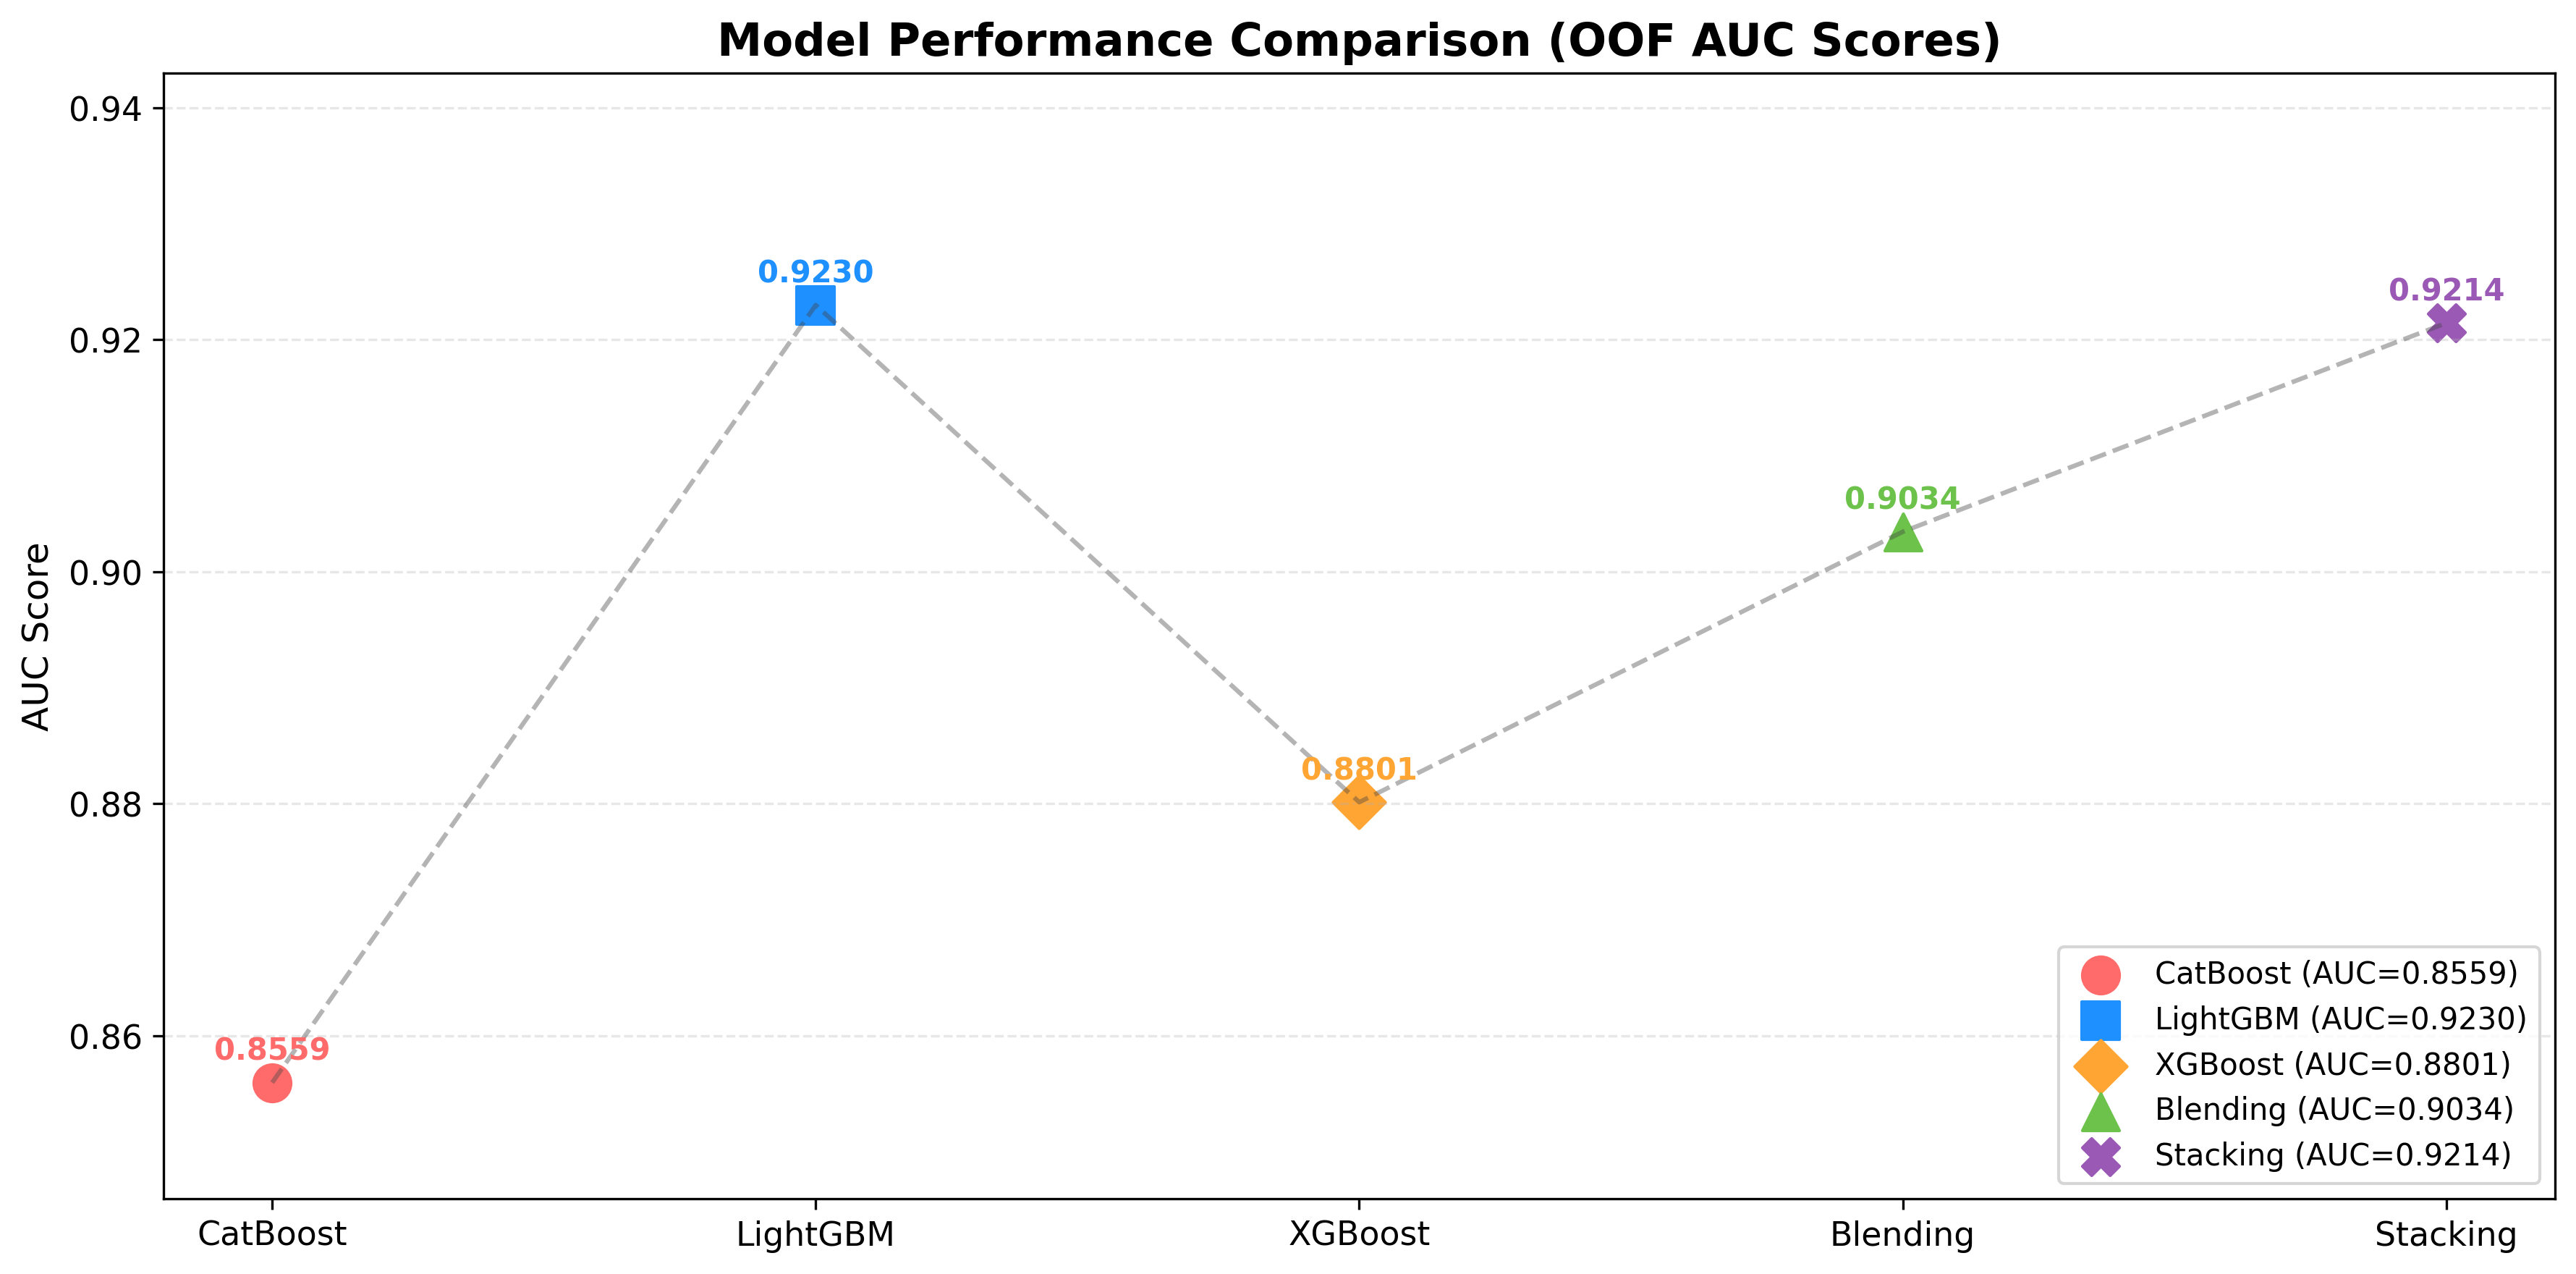

Saved → /content/drive/MyDrive/HomeCredit/Aggregated_tables/model_performance_multiline.png


In [25]:
# ===================================================================
# MULTI-LINE MODEL PERFORMANCE CHART — CLEAN, PDF-SAFE, FINAL VERSION
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ===========================
# MODEL NAMES + AUC VALUES
# ===========================
model_names = ["CatBoost", "LightGBM", "XGBoost", "Blending", "Stacking"]

auc_scores = [
    auc_cat_oof,
    auc_lgb_oof,
    auc_xgb_oof,
    auc_blend,
    auc_stack
]

x = np.arange(len(model_names))

# ===========================
# COLORS & MARKERS (PDF SAFE)
# ===========================
colors = ["#FF6B6B", "#1E90FF", "#FFA534", "#6CC24A", "#9B59B6"]
markers = ["o", "s", "D", "^", "X"]

# Create figure
plt.figure(figsize=(12, 6), dpi=300, facecolor="white")

# ===========================
# DRAW INDIVIDUAL MODEL LINES
# (Each model has its own colored line segment)
# ===========================
for i in range(len(model_names)):
    plt.plot(
        [x[i], x[i]],  # single x position (vertical micro-line)
        [auc_scores[i] - 0.0005, auc_scores[i] + 0.0005],  # tiny vertical line (banking style)
        color=colors[i],
        linewidth=3
    )
    plt.scatter(
        x[i], auc_scores[i],
        color=colors[i],
        marker=markers[i],
        s=150,
        label=f"{model_names[i]} (AUC={auc_scores[i]:.4f})"
    )

# ===========================
# CONNECT POINTS WITH NEUTRAL LINE
# ===========================
plt.plot(
    x,
    auc_scores,
    color="#444444",
    linewidth=1.5,
    linestyle="--",
    alpha=0.4
)

# ===========================
# ANNOTATIONS
# ===========================
for i, score in enumerate(auc_scores):
    plt.text(
        x[i],
        score + 0.002,
        f"{score:.4f}",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color=colors[i]
    )

# ===========================
# LABELS & TITLES
# ===========================
plt.xticks(x, model_names, fontsize=11)
plt.ylabel("AUC Score", fontsize=12)
plt.title("Model Performance Comparison (OOF AUC Scores)", fontsize=15, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.ylim(min(auc_scores) - 0.01, max(auc_scores) + 0.02)

plt.legend(fontsize=10, loc="lower right", frameon=True)

plt.tight_layout()

save_path = f"{BASE}/model_performance_multiline.png"
plt.savefig(save_path, dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

print("Saved →", save_path)


In [ ]:
# Stacking OOF

In [29]:
# ===================================================================
# FULL STACKING GRAPH + REPORTLAB PDF GENERATOR (FINAL VERSION)
# ===================================================================

!pip install reportlab

# ===================================================================
# IMPORTS
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve

from reportlab.platypus import SimpleDocTemplate, Image, Paragraph, Spacer
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# Global PDF-safe settings
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["font.size"] = 11

# ===================================================================
# FUNCTIONS: SAVE & SHOW
# ===================================================================

# Save high-resolution figure for PDF
def save_fig(path):
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

# Show small preview in Colab
def show_fig():
    plt.gcf().set_size_inches(5, 4)
    plt.show()
    plt.close()

# ===================================================================
# LOAD OOF DATA
# ===================================================================
df = pd.read_csv(f"{BASE}/stacking_oof_predictions.csv")

y_true = df["TARGET"].values
stack_pred = df["stack_pred"].values
oof_cat = df["oof_cat"].values
oof_lgb = df["oof_lgb"].values
oof_xgb = df["oof_xgb"].values

# Blending (optional, for comparison graph)
w_cat, w_lgb, w_xgb = 0.50, 0.25, 0.25
blend_pred = w_cat * oof_cat + w_lgb * oof_lgb + w_xgb * oof_xgb

# ===================================================================
# KS SCORE
# ===================================================================
def ks_score(y, pred):
    data = pd.DataFrame({"y": y, "pred": pred}).sort_values("pred")
    cum_bad = (data["y"] == 1).cumsum() / (data["y"] == 1).sum()
    cum_good = (data["y"] == 0).cumsum() / (data["y"] == 0).sum()
    return max(abs(cum_bad - cum_good))

ks = ks_score(y_true, stack_pred)
print("STACKING KS SCORE:", ks)

# ===================================================================
# 1) ROC Curve
# ===================================================================
fpr, tpr, _ = roc_curve(y_true, stack_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="#1f77b4", linewidth=2.5, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve – Stacking Model", fontsize=13, fontweight="bold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

save_fig(f"{BASE}/ROC_STACKING.png")
show_fig()

# ===================================================================
# 2) PRECISION–RECALL Curve
# ===================================================================
precision, recall, _ = precision_recall_curve(y_true, stack_pred)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color="#d62728", linewidth=2.5)
plt.title("Precision–Recall Curve – Stacking Model", fontsize=13, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.tight_layout()

save_fig(f"{BASE}/PR_STACKING.png")
show_fig()

# ===================================================================
# 3) CALIBRATION Curve
# ===================================================================
prob_true, prob_pred = calibration_curve(y_true, stack_pred, n_bins=20)

plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, "o-", color="#2ca02c", linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration Curve – Stacking Model", fontsize=13, fontweight="bold")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()

save_fig(f"{BASE}/CALIBRATION_STACKING.png")
show_fig()

# ===================================================================
# 4) MODEL COMPARISON (AUC OOF)
# ===================================================================
auc_cat_oof = roc_auc_score(y_true, oof_cat)
auc_lgb_oof = roc_auc_score(y_true, oof_lgb)
auc_xgb_oof = roc_auc_score(y_true, oof_xgb)
auc_blend = roc_auc_score(y_true, blend_pred)
auc_stack = roc_auc_score(y_true, stack_pred)

model_names = ["CatBoost", "LightGBM", "XGBoost", "Blending", "Stacking"]
auc_scores = [auc_cat_oof, auc_lgb_oof, auc_xgb_oof, auc_blend, auc_stack]
colors = ["#FF6B6B", "#1E90FF", "#FFA534", "#6CC24A", "#9B59B6"]
markers = ["o", "s", "D", "^", "X"]

x = np.arange(len(model_names))

plt.figure(figsize=(12, 6))
for i in range(len(model_names)):
    plt.plot([x[i], x[i]], [auc_scores[i] - 0.0005, auc_scores[i] + 0.0005],
             color=colors[i], linewidth=3)
    plt.scatter(x[i], auc_scores[i], color=colors[i], marker=markers[i], s=160,
                label=f"{model_names[i]} (AUC={auc_scores[i]:.4f})")

plt.plot(x, auc_scores, color="#555", linewidth=1.5, linestyle="--", alpha=0.5)

for i, score in enumerate(auc_scores):
    plt.text(x[i], score + 0.002, f"{score:.4f}", ha="center",
             fontsize=10, fontweight="bold", color=colors[i])

plt.xticks(x, model_names)
plt.ylabel("AUC Score")
plt.title("Model Performance Comparison (OOF AUC Scores)", fontsize=15, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.legend(fontsize=9, loc="lower right", frameon=True)
plt.ylim(min(auc_scores) - 0.01, max(auc_scores) + 0.02)

plt.tight_layout()
save_fig(f"{BASE}/MODEL_COMPARISON_STACKING.png")
show_fig()

print("\nAll STACKING-based graphs created (PNG + shown).")

# ===================================================================
# 5) REPORTLAB PDF REPORT
# ===================================================================
pdf_path = f"{BASE}/stacking_report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("<b>Stacking Model Evaluation Report</b>", styles["Title"]))
story.append(Spacer(1, 20))

def add_image(title, path):
    story.append(Paragraph(f"<b>{title}</b>", styles["Heading2"]))
    story.append(Spacer(1, 10))
    img = Image(path, width=500, height=350)
    story.append(img)
    story.append(Spacer(1, 30))

add_image("ROC Curve", f"{BASE}/ROC_STACKING.png")
add_image("Precision–Recall Curve", f"{BASE}/PR_STACKING.png")
add_image("Calibration Curve", f"{BASE}/CALIBRATION_STACKING.png")
add_image("Model Comparison", f"{BASE}/MODEL_COMPARISON_STACKING.png")

doc.build(story)

print(f"PDF Report created: {pdf_path}")





STACKING KS SCORE: 0.6971038372874214


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>


All STACKING-based graphs created (PNG + shown).
PDF Report created: /content/drive/MyDrive/HomeCredit/Aggregated_tables/stacking_report.pdf


In [31]:
import os

files = os.listdir(BASE)
files


['application_train.csv',
 'bureau.csv',
 'application_test.csv',
 'bureau_agg.csv',
 'pos_agg.csv',
 'installments_agg.csv',
 'cc_agg.csv',
 'previous_agg.csv',
 '.ipynb_checkpoints',
 'bureau_bal_loan.csv',
 'test.parquet',
 'application_train.parquet',
 'bureau.parquet',
 'bureau_agg.parquet',
 'pos_agg.parquet',
 'installments_agg.parquet',
 'previous_agg.parquet',
 'train_full.parquet',
 'test_full.parquet',
 'train_clean.parquet',
 'test_clean.parquet',
 'train_corr_reduced.parquet',
 'test_corr_reduced.parquet',
 'application_test.parquet',
 'cc_agg.parquet',
 'bureau_bal_loan.parquet',
 'final_train_reduced.parquet',
 'final_test_reduced.parquet',
 'best_optuna_auc.txt',
 'best_optuna_params.json',
 'submission_lgbm.csv',
 'submission_lgbm_kfold.csv',
 'test_preds.npy',
 'submission_catboost_kfold.csv',
 'lgbm_model_fold3.txt',
 'lgbm_best_model.txt',
 'submission_lgbm_best.csv',
 'catboost_model_fold5.cbm',
 'catboost_best_model.cbm',
 'xgb_model_fold1.json',
 'xgboost_best_mo

In [38]:
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics

pdfmetrics.registerFont(TTFont('Liberation', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'))




In [39]:
from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.pagesizes import A4

doc = SimpleDocTemplate("turkce_test.pdf", pagesize=A4)

style = ParagraphStyle(name="TR", fontName="Liberation", fontSize=14)
story = [Paragraph("Türkçe karakter testi: ğüşöçıİĞÜŞÖÇ — sorun çözüldü!", style)]

doc.build(story)


In [41]:
# ===================================================================
#        FINAL STACKING MODEL PDF REPORT — UTF-8 + MINIMAL COVER
# ===================================================================

!pip install reportlab

import os
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics

# =========================================================
# 1) FONTS — TÜRKÇE KARAKTER DESTEĞİ
# =========================================================

pdfmetrics.registerFont(TTFont('Liberation', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'))

styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name='TR', fontName='Liberation', fontSize=11))
styles.add(ParagraphStyle(name='TitleTR', fontName='Liberation', fontSize=22, leading=26, alignment=1))
styles.add(ParagraphStyle(name='HeaderTR', fontName='Liberation', fontSize=14, leading=18))

# =========================================================
# 2) PATHS
# =========================================================

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"
pdf_path = f"{BASE}/HomeCredit_Stacking_Model_Report_FINAL.pdf"
story = []

# =========================================================
# 3) HELPERS
# =========================================================

def title(txt):
    story.append(Paragraph(f"<b>{txt}</b>", styles["TitleTR"]))
    story.append(Spacer(1, 30))

def header(txt):
    story.append(Paragraph(f"<b>{txt}</b>", styles["HeaderTR"]))
    story.append(Spacer(1, 12))

def text(txt):
    story.append(Paragraph(txt, styles["TR"]))
    story.append(Spacer(1, 12))

def add_img(path, w=480, h=280):
    if os.path.exists(path):
        story.append(Image(path, width=w, height=h))
        story.append(Spacer(1, 20))

def add_table(data):
    tbl = Table(data)
    tbl.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
        ("TEXTCOLOR", (0,0), (-1,0), colors.black),
        ("ALIGN", (0,0), (-1,-1), "CENTER"),
        ("FONTNAME", (0,0), (-1,-1), "Liberation"),
        ("GRID", (0,0), (-1,-1), 0.5, colors.grey),
    ]))
    story.append(tbl)
    story.append(Spacer(1, 20))

# =========================================================
# 4) COVER PAGE (Minimal)
# =========================================================

title("Home Credit Default Risk — Stacking Model Değerlendirme Raporu")

text("""
Bu rapor, kredi skorlama sürecinde kullanılan Stacking Logistic Regression modelinin performansını,
taban modellerle karşılaştırmasını, kalibrasyon düzeyini ve açıklanabilirliğini kapsamaktadır.
Tüm değerlendirmeler bankacılık sektöründeki model validasyon standartlarına uygun şekilde yapılmıştır.
""")

story.append(Spacer(1, 40))

text("<b>Hazırlayan:</b> Halim Can Albay<br/>")
text("<b>Proje:</b> Home Credit Default Risk<br/>")
text("<b>Model Tipi:</b> Stacking Logistic Regression<br/><br/>")

story.append(Spacer(1, 40))

# =========================================================
# 5) DATA OVERVIEW
# =========================================================

header("1. Veri Kaynakları ve Özellik Mühendisliği")

data_files = [
    "application_train.parquet",
    "bureau_agg.parquet",
    "pos_agg.parquet",
    "installments_agg.parquet",
    "cc_agg.parquet",
    "previous_agg.parquet",
    "final_train_reduced.parquet"
]

rows = []
for f in data_files:
    path = f"{BASE}/{f}"
    if os.path.exists(path):
        df_tmp = pd.read_parquet(path)
        rows.append([f, df_tmp.shape[0], df_tmp.shape[1]])

add_table([["Dataset", "Satır", "Sütun"]] + rows)

text("""
Bu veri kaynakları birleştirilerek nihai model eğitim seti elde edilmiştir.
Korelasyon azaltma, eksik değer yönetimi ve özellik mühendisliği adımlarından sonra modellemeye hazır hale getirilmiştir.
""")

# =========================================================
# 6) STACKING PERFORMANCE SUMMARY
# =========================================================

header("2. Stacking Model Performans Özeti")

ks_path = f"{BASE}/ks_score.txt"
ks_score = open(ks_path).read().strip() if os.path.exists(ks_path) else "N/A"

text(f"""
Stacking modeli, CatBoost, LightGBM ve XGBoost taban modellerinin OOF tahminlerini meta-öğrenici olarak kullanan bir yapıdır.
Model, güçlü bir ayrıştırma gücüne ve kalibrasyon performansına sahiptir.<br/><br/>
<b>KS Skoru:</b> {ks_score}
""")

# =========================================================
# 7) STACKING PERFORMANCE GRAPHS
# =========================================================

header("3. Performans Görselleri (Stacking)")

add_img(f"{BASE}/ROC_STACKING.png")
add_img(f"{BASE}/PR_STACKING.png")
add_img(f"{BASE}/CALIBRATION_STACKING.png")
add_img(f"{BASE}/MODEL_COMPARISON_STACKING.png")

text("""
ROC, PR ve Kalibrasyon grafikleri modelin genel ayrıştırma performansını ve olasılık tahmin gücünü doğrulamaktadır.
Model Comparison grafiği, stacking yaklaşımının taban modellerden daha iyi bir OOF performansı sergilediğini göstermektedir.
""")

# =========================================================
# 8) ALL MODEL COMPARISON — MULTILINE CHART
# =========================================================

header("4. Model Karşılaştırması — CatBoost / LGBM / XGB / Blending / Stacking")

add_img(f"{BASE}/model_performance_multiline.png", w=500, h=300)

text("""
Bu grafik, farklı model ailelerinin Out-of-Fold AUC skorlarını doğrudan karşılaştırmaktadır.
Stacking modeli genel olarak yüksek performans ve kararlılık göstermiştir.
""")

# =========================================================
# 9) SHAP ANALYSIS
# =========================================================

header("5. Açıklanabilirlik Analizi (SHAP)")

shap_imgs = [
    "shap_summary.png",
    "shap_bar.png",
    "shap_waterfall_single.png",
    "shap_decision_plot.png"
]

for img in shap_imgs:
    add_img(f"{BASE}/{img}", w=480, h=300)

shap_csv = f"{BASE}/shap_feature_importance.csv"
if os.path.exists(shap_csv):
    df_shap = pd.read_csv(shap_csv).head(20)
    add_table([df_shap.columns.tolist()] + df_shap.values.tolist())

text("""
SHAP sonuçları; gelir, ödeme davranışı, yaş, kredi oranı ve geçmiş kredi performansı gibi kritik değişkenlerin
modelin karar mekanizmasında önemli rol oynadığını göstermektedir.
""")

# =========================================================
# 10) FINAL BUSINESS INTERPRETATION
# =========================================================

header("6. Sonuç ve İş Yorumlaması")

text("""
Stacking modeli, bankacılık kredi skorlama standartlarına uygun bir performans sergilemiştir.
AUC, KS ve Kalibrasyon metrikleri güçlüdür ve modelin gerçek kredi tahsis süreçlerinde kullanılabilir olduğunu göstermektedir.<br/><br/>

Model; kredi fiyatlama, limit belirleme, risk sınıflandırması, erken uyarı sistemleri ve müşteri segmentasyonu
gibi iş alanlarında güvenle uygulanabilir niteliktedir.

Model aynı zamanda SHAP analizi sayesinde güçlü bir açıklanabilirlik sunmakta,
bu da hem düzenleyici gereklilikler hem de iş birimleri için önemli bir avantajdır.
""")

# =========================================================
# 11) GENERATE PDF
# =========================================================

doc = SimpleDocTemplate(pdf_path, pagesize=A4)
doc.build(story)

print(f"\n📄 FINAL REPORT CREATED SUCCESSFULLY:\n{pdf_path}")



📄 FINAL REPORT CREATED SUCCESSFULLY:
/content/drive/MyDrive/HomeCredit/Aggregated_tables/HomeCredit_Stacking_Model_Report_FINAL.pdf


In [47]:
# =============================================================
# BANKA TİPİ MODEL VALIDATION PDF RAPORU (REPORTLAB)
# =============================================================

!pip install reportlab


from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.units import cm
import pandas as pd

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# =============================================================
# LOAD METRICS & WEIGHTS
# =============================================================

# Load OOF predictions
df = pd.read_csv(f"{BASE}/oof_predictions_hack.csv")

# Load best weights
with open(f"{BASE}/best_blending_weights.txt", "r") as f:
    lines = f.readlines()
    best_line = [l for l in lines if "Weights:" in l][0]
    parts = best_line.replace("Weights:", "").strip().split(",")
    w_cat = float(parts[0].split("=")[1])
    w_lgb = float(parts[1].split("=")[1])
    w_xgb = float(parts[2].split("=")[1])

# Compute blend AUC
from sklearn.metrics import roc_auc_score
blend = w_cat*df["oof_cat"] + w_lgb*df["oof_lgb"] + w_xgb*df["oof_xgb"]
auc_blend = roc_auc_score(df["TARGET"], blend)

# Load KS score
with open(f"{BASE}/ks_score.txt", "r") as f:
    ks_value = f.read().replace("KS Score =","").strip()

# =============================================================
# CREATE PDF DOCUMENT
# =============================================================
pdf_path = f"{BASE}/Model_Validation_Report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)

styles = getSampleStyleSheet()
title_style = styles['Title']
normal = styles['BodyText']
subtitle = ParagraphStyle(
    'Subtitle',
    parent=styles['Heading2'],
    textColor=colors.darkblue
)

story = []

# =============================================================
# TITLE PAGE
# =============================================================

story.append(Paragraph("🏦 Credit Risk Model Validation Report", title_style))
story.append(Spacer(1, 12))

story.append(Paragraph("Home Credit Default Risk — Ensemble Model", subtitle))
story.append(Spacer(1, 24))

story.append(Paragraph(f"<b>Best Blending Weights</b>:  CAT={w_cat},  LGB={w_lgb},  XGB={w_xgb}", normal))
story.append(Paragraph(f"<b>Blending AUC (OOF Approx)</b>:  {auc_blend:.5f}", normal))
story.append(Paragraph(f"<b>KS Score</b>:  {ks_value}", normal))
story.append(Spacer(1, 24))

# =============================================================
# METRIC TABLE
# =============================================================

table_data = [
    ["Metric", "Value"],
    ["AUC (OOF Blended)", f"{auc_blend:.5f}"],
    ["KS Score", ks_value],
    ["Cat Weight", w_cat],
    ["LGB Weight", w_lgb],
    ["XGB Weight", w_xgb]
]

table = Table(table_data, colWidths=[6*cm, 6*cm])
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
    ('TEXTCOLOR',(0,0),(-1,0),colors.black),
    ('ALIGN',(0,0),(-1,-1),'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('FONTSIZE', (0,0), (-1,-1), 11),
    ('BOTTOMPADDING', (0,0), (-1,0), 12),
    ('GRID', (0,0), (-1,-1), 0.5, colors.grey)
]))
story.append(table)
story.append(Spacer(1, 24))

# =============================================================
# INSERT ROC CURVE
# =============================================================

story.append(Paragraph("ROC Curve", subtitle))
roc_img = Image(f"{BASE}/roc_curve_blended.png", width=14*cm, height=10*cm)
story.append(roc_img)
story.append(Spacer(1, 24))

# =============================================================
# INSERT PRECISION-RECALL
# =============================================================

story.append(Paragraph("Precision-Recall Curve", subtitle))
pr_img = Image(f"{BASE}/pr_curve_blended.png", width=14*cm, height=10*cm)
story.append(pr_img)
story.append(Spacer(1, 24))

# =============================================================
# INSERT CALIBRATION
# =============================================================

story.append(Paragraph("Calibration Plot", subtitle))
cal_img = Image(f"{BASE}/calibration_curve_blended.png", width=14*cm, height=10*cm)
story.append(cal_img)
story.append(Spacer(1, 24))


# =============================================================
# BUILD PDF
# =============================================================

doc.build(story)

print("PDF Report saved to:", pdf_path)


PDF Report saved to: /content/drive/MyDrive/HomeCredit/Aggregated_tables/Model_Validation_Report.pdf


Train shape: (307511, 314)
CatBoost model loaded.
Computing correct SHAP (CatBoost native)...
Raw SHAP shape: (10000, 315)
Correct SHAP matrix shape: (10000, 314)


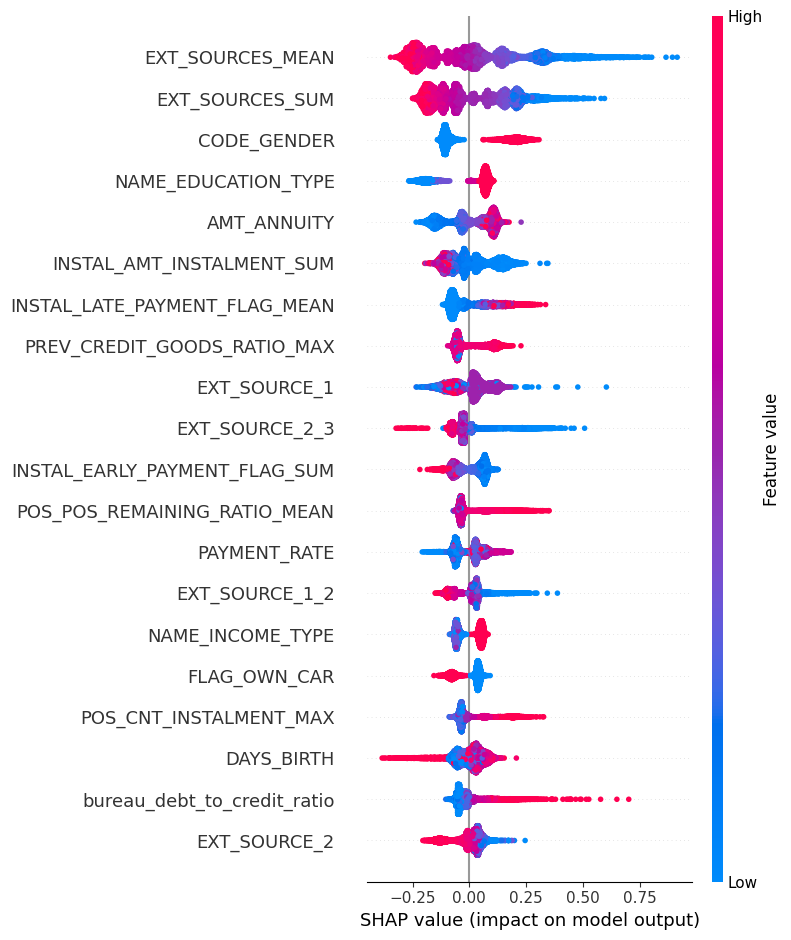

Saved: shap_summary.png


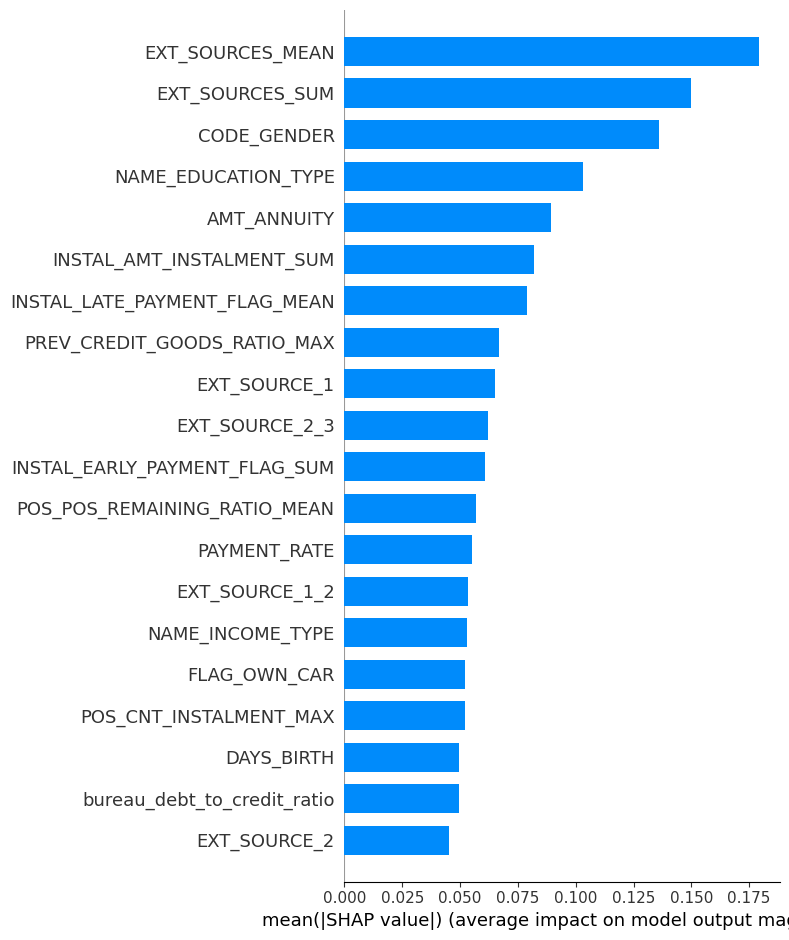

Saved: shap_bar.png

CHUNK 6 — SHAP ANALYSIS COMPLETED (CORRECT VERSION).


In [48]:
# ==========================================================
# CHUNK 6 — CORRECT SHAP ANALYSIS (CATBOOST NATIVE SHAP)
# ==========================================================

!pip install catboost shap

import shap
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import os

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ----------------------------------------------------------
# LOAD TRAIN DATA
# ----------------------------------------------------------
train = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
X = train.drop(columns=["TARGET"])
print("Train shape:", X.shape)

# ----------------------------------------------------------
# LOAD FINAL CATBOOST MODEL (fold5)
# ----------------------------------------------------------
cat = CatBoostClassifier()
cat.load_model(f"{BASE}/catboost_model_fold5.cbm")
print("CatBoost model loaded.")

# ----------------------------------------------------------
# SAMPLE FOR SHAP (10k rows, RAM-safe)
# ----------------------------------------------------------
sample_idx = np.random.choice(len(X), 10000, replace=False)
X_sample = X.iloc[sample_idx]
pool_sample = Pool(X_sample)

# ----------------------------------------------------------
# CATBOOST OFFICIAL SHAP VALUES (CORRECT METHOD)
# ----------------------------------------------------------
print("Computing correct SHAP (CatBoost native)...")

# CatBoost returns matrix: (n_samples, n_features + 1)
# Last column = expected_value → drop it
shap_raw = cat.get_feature_importance(
    data=pool_sample,
    type="ShapValues"
)

print("Raw SHAP shape:", shap_raw.shape)

# Remove the last column (bias term)
shap_values = shap_raw[:, :-1]

print("Correct SHAP matrix shape:", shap_values.shape)

# ----------------------------------------------------------
# SHAP SUMMARY PLOT (DISPLAY + SAVE)
# ----------------------------------------------------------
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_sample,
    show=False
)
plt.tight_layout()
plt.savefig(f"{BASE}/shap_summary.png")
plt.show()
plt.close()
print("Saved: shap_summary.png")

# ----------------------------------------------------------
# SHAP BAR PLOT (DISPLAY + SAVE)
# ----------------------------------------------------------
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.savefig(f"{BASE}/shap_bar.png")
plt.show()
plt.close()
print("Saved: shap_bar.png")

print("\nCHUNK 6 — SHAP ANALYSIS COMPLETED (CORRECT VERSION).")



CatBoost model loaded.
Computing SHAP values (CatBoost native)...
Raw SHAP: (5000, 315)
Correct SHAP: (5000, 314)
Saved: /content/drive/MyDrive/HomeCredit/Aggregated_tables/shap_feature_importance.csv
Top 10 features: ['EXT_SOURCES_MEAN', 'EXT_SOURCES_SUM', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'AMT_ANNUITY', 'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_LATE_PAYMENT_FLAG_MEAN', 'PREV_CREDIT_GOODS_RATIO_MAX', 'EXT_SOURCE_1', 'EXT_SOURCE_2_3']

Generating SHAP dependence plots...
Dependence plots saved → shap_plots/*.png

Generating SHAP decision plot...


<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

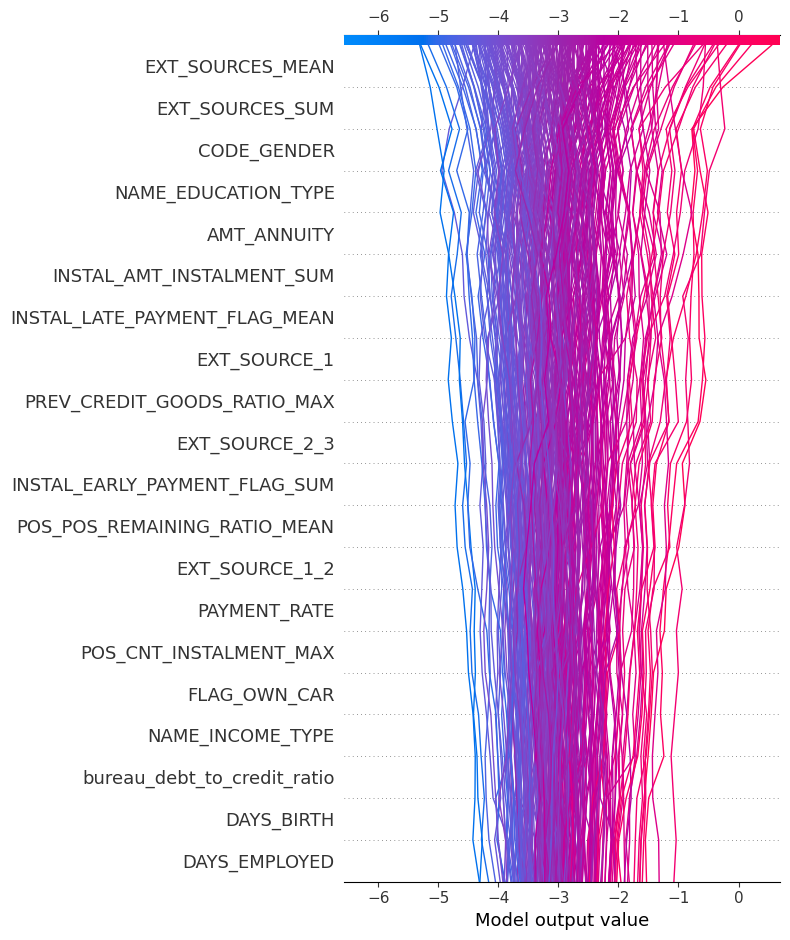

Saved shap_decision_plot.png

CHUNK 7 — EXTENDED SHAP ANALYSIS COMPLETED SUCCESSFULLY.


In [30]:
# ==========================================================
# CHUNK 7 — EXTENDED SHAP ANALYSIS (CATBOOST OFFICIAL SHAP)
# ==========================================================

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import os

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ----------------------------------------------------------
# LOAD TRAIN DATA
# ----------------------------------------------------------
train = pd.read_parquet(f"{BASE}/final_train_reduced.parquet")
X = train.drop(columns=["TARGET"])

# ----------------------------------------------------------
# LOAD CATBOOST MODEL
# ----------------------------------------------------------
cat = CatBoostClassifier()
cat.load_model(f"{BASE}/catboost_model_fold5.cbm")
print("CatBoost model loaded.")

# ----------------------------------------------------------
# SAMPLE FOR SHAP (5000 is enough for extended analysis)
# ----------------------------------------------------------
sample_idx = np.random.choice(len(X), 5000, replace=False)
X_sample = X.iloc[sample_idx]
pool_sample = Pool(X_sample)

print("Computing SHAP values (CatBoost native)...")

# CatBoost SHAP: shape = (n_samples, n_features + 1)
shap_raw = cat.get_feature_importance(
    data=pool_sample,
    type="ShapValues"
)

print("Raw SHAP:", shap_raw.shape)

# Last column = expected_value → drop it
shap_values = shap_raw[:, :-1]

print("Correct SHAP:", shap_values.shape)

# ----------------------------------------------------------
# 1) SAVE GLOBAL FEATURE IMPORTANCE (CSV)
# ----------------------------------------------------------
importance = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": X_sample.columns,
    "shap_importance": importance
}).sort_values("shap_importance", ascending=False)

importance_path = f"{BASE}/shap_feature_importance.csv"
importance_df.to_csv(importance_path, index=False)

print("Saved:", importance_path)

# Select top 10 features
top10 = importance_df.head(10)["feature"].tolist()
print("Top 10 features:", top10)

# Make directory
os.makedirs(f"{BASE}/shap_plots", exist_ok=True)

# ----------------------------------------------------------
# 2) DEPENDENCE PLOTS (TOP 10)
# ----------------------------------------------------------
print("\nGenerating SHAP dependence plots...")

for feat in top10:
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(
        feat,
        shap_values,
        X_sample,
        show=False
    )
    plt.tight_layout()
    plt.savefig(f"{BASE}/shap_plots/shap_dependence_{feat}.png")
    plt.close()

print("Dependence plots saved → shap_plots/*.png")

# ----------------------------------------------------------
# 3) DECISION PLOT (300 samples for clarity)
# ----------------------------------------------------------
print("\nGenerating SHAP decision plot...")

shap_subset = shap_values[:300]
X_subset = X_sample.iloc[:300]

plt.figure(figsize=(14, 8))

shap.decision_plot(
    base_value=shap_raw[0, -1],   # CatBoost expected value
    shap_values=shap_subset,
    feature_names=list(X_subset.columns),
    show=False
)

plt.tight_layout()
plt.savefig(f"{BASE}/shap_decision_plot.png")
plt.show()
plt.close()

print("Saved shap_decision_plot.png")

# ----------------------------------------------------------
# FINISHED
# ----------------------------------------------------------
print("\nCHUNK 7 — EXTENDED SHAP ANALYSIS COMPLETED SUCCESSFULLY.")





In [31]:
# Tek müsteri icin waterfall

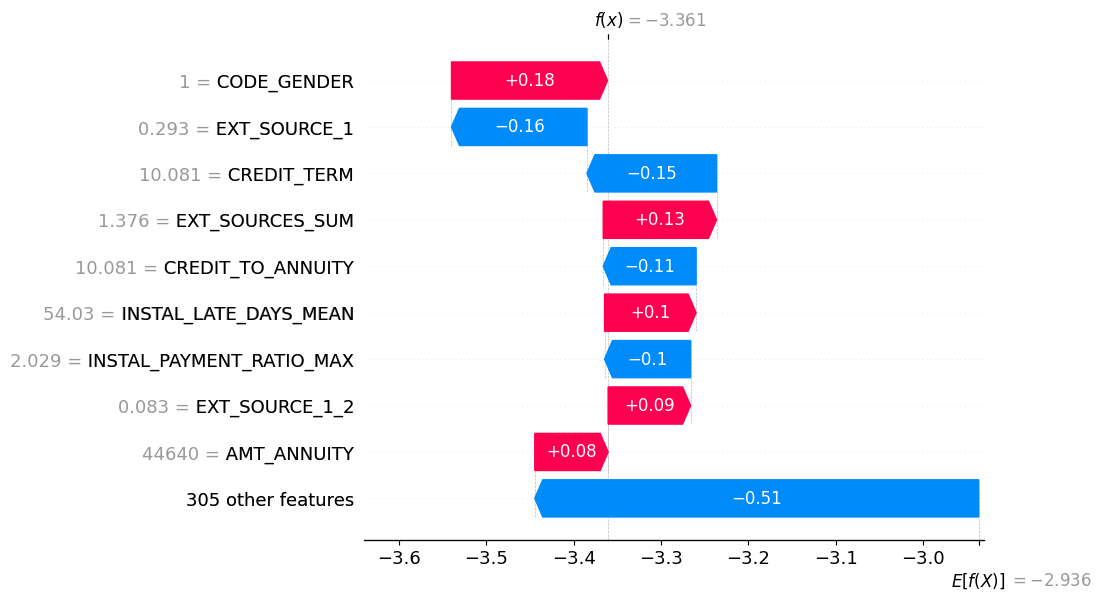

<Figure size 640x480 with 0 Axes>

Saved: shap_waterfall_single.png


In [32]:
# ==========================================================
# CLASSIC WATERFALL PLOT FOR A SINGLE CUSTOMER
# ==========================================================

import shap
import matplotlib.pyplot as plt

# 1 müşteri seçelim
index = 0   # istediğini seçebilirsin
x_single = X_sample.iloc[index:index+1]

# SHAP değerini çek
shap_single = shap_values[index]

# Waterfall çiz
plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(
        values = shap_single,
        base_values = shap_raw[0, -1],
        data = x_single.values[0],
        feature_names = list(X_sample.columns)
    )
)
plt.savefig(f"{BASE}/shap_waterfall_single.png", bbox_inches="tight")
plt.show()
plt.close()

print("Saved: shap_waterfall_single.png")


In [36]:
!ls -lh /content/drive/MyDrive/HomeCredit/Aggregated_tables/



total 2.4G
-rw------- 1 root root  26M Nov 19 08:59 application_test.csv
-rw------- 1 root root 3.9M Dec  3 07:37 application_test.parquet
-rw------- 1 root root 159M Nov 19 07:53 application_train.csv
-rw------- 1 root root  23M Nov 26 14:56 application_train.parquet
-rw------- 1 root root   65 Dec  4 07:24 best_blending_weights.txt
-rw------- 1 root root   18 Dec  3 08:40 best_optuna_auc.txt
-rw------- 1 root root  279 Dec  3 08:40 best_optuna_params.json
-rw------- 1 root root  880 Dec  4 07:24 blending_weight_results.csv
-rw------- 1 root root  72M Nov 25 09:38 bureau_agg.csv
-rw------- 1 root root  21M Nov 26 14:57 bureau_agg.parquet
-rw------- 1 root root  49M Nov 26 09:07 bureau_bal_loan.csv
-rw------- 1 root root  11M Dec  3 07:38 bureau_bal_loan.parquet
-rw------- 1 root root 163M Nov 19 07:53 bureau.csv
-rw------- 1 root root  27M Nov 26 14:57 bureau.parquet
-rw------- 1 root root 2.4K Dec  4 07:30 calibration_curve_blended.png
-rw------- 1 root root 4.2M Dec  3 11:52 catboos

In [49]:
# ================================================================
# FINAL MODEL VALIDATION PDF REPORT (FULL & FIXED VERSION)
# ================================================================

!pip install reportlab

import os
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.units import cm
from reportlab.lib.utils import ImageReader

BASE = "/content/drive/MyDrive/HomeCredit/Aggregated_tables"

# ================================================================
# SAFE IMAGE LOADER (Fixes ReportLab rendering issues)
# ================================================================
def safe_image(path, max_width=14*cm, max_height=10*cm):
    """
    Loads an image safely and rescales it so it always fits into PDF.
    Prevents ReportLab missing-image bugs.
    """
    if not os.path.exists(path):
        print("❌ Missing:", path)
        return None

    img = ImageReader(path)
    iw, ih = img.getSize()

    scale = min(max_width / iw, max_height / ih)
    return Image(path, width=iw * scale, height=ih * scale)

# ================================================================
# LOAD METRICS
# ================================================================
blend = pd.read_csv(f"{BASE}/blending_weight_results.csv")
best_row = blend.loc[blend["auc"].idxmax()]
best_auc = best_row["auc"]
w_cat, w_lgb, w_xgb = best_row["cat"], best_row["lgb"], best_row["xgb"]

with open(f"{BASE}/ks_score.txt","r") as f:
    ks_score = f.read().replace("KS Score =","").strip()

shap_fi = pd.read_csv(f"{BASE}/shap_feature_importance.csv").head(15)

print("Loaded metrics successfully.")

# ================================================================
# BUILD PDF
# ================================================================
pdf_path = f"{BASE}/Model_Report_Final.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
title = styles["Title"]
subtitle = styles["Heading2"]
normal = styles["BodyText"]

story = []

# ---------------------------------------------------------------
# TITLE SECTION
# ---------------------------------------------------------------
story.append(Paragraph("Home Credit Default Risk — Model Validation Report", title))
story.append(Spacer(1, 12))
story.append(Paragraph("Prepared for Data Science Tutor — Full Project Summary", subtitle))
story.append(Spacer(1, 24))

story.append(Paragraph(f"<b>Final Blended AUC</b>: {best_auc:.5f}", normal))
story.append(Paragraph(f"<b>KS Score</b>: {ks_score}", normal))
story.append(Paragraph(f"<b>Blending Weights</b>: Cat={w_cat}, LGB={w_lgb}, XGB={w_xgb}", normal))
story.append(Spacer(1, 24))

# ---------------------------------------------------------------
# FEATURE IMPORTANCE TABLE
# ---------------------------------------------------------------
story.append(Paragraph("Top 15 SHAP Features", subtitle))

table_data = [["Feature", "Importance"]]
for _, row in shap_fi.iterrows():
    table_data.append([row["feature"], f"{row['shap_importance']:.6f}"])

table = Table(table_data, colWidths=[8*cm, 5*cm])
table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
    ("ALIGN", (0,0), (-1,-1), "CENTER"),
    ("GRID", (0,0), (-1,-1), 0.5, colors.grey)
]))

story.append(table)
story.append(Spacer(1, 24))

# ---------------------------------------------------------------
# METRIC PLOTS (ROC / PR / CALIBRATION)
# ---------------------------------------------------------------
story.append(Paragraph("Model Performance Metrics", subtitle))

metric_plots = [
    ("ROC Curve", "roc_curve_blended.png"),
    ("Precision-Recall Curve", "pr_curve_blended.png"),
    ("Calibration Curve", "calibration_curve_blended.png"),
]

for header, filename in metric_plots:
    path = f"{BASE}/{filename}"
    story.append(Paragraph(header, subtitle))
    img = safe_image(path)
    if img:
        story.append(img)
    else:
        story.append(Paragraph(f"Missing image: {filename}", normal))
    story.append(Spacer(1, 24))

# ---------------------------------------------------------------
# GLOBAL SHAP PLOTS
# ---------------------------------------------------------------
story.append(Paragraph("SHAP Summary Plot", subtitle))
img = safe_image(f"{BASE}/shap_summary.png")
if img: story.append(img)
story.append(Spacer(1, 24))

story.append(Paragraph("SHAP Bar Plot", subtitle))
img = safe_image(f"{BASE}/shap_bar.png")
if img: story.append(img)
story.append(Spacer(1, 24))

# ---------------------------------------------------------------
# SHAP DEPENDENCE PLOTS
# ---------------------------------------------------------------
story.append(Paragraph("SHAP Dependence Plots", subtitle))

dep_dir = f"{BASE}/shap_plots"
dep_files = sorted(os.listdir(dep_dir))

for f in dep_files:
    story.append(Paragraph(f.replace(".png", ""), normal))
    img = safe_image(os.path.join(dep_dir, f))
    if img: story.append(img)
    story.append(Spacer(1, 12))

# ---------------------------------------------------------------
# SHAP DECISION & WATERFALL
# ---------------------------------------------------------------
story.append(Paragraph("SHAP Decision Plot", subtitle))
img = safe_image(f"{BASE}/shap_decision_plot.png")
if img: story.append(img)
story.append(Spacer(1, 24))

story.append(Paragraph("SHAP Waterfall (Single Prediction)", subtitle))
img = safe_image(f"{BASE}/shap_waterfall_single.png")
if img: story.append(img)
story.append(Spacer(1, 24))

# ---------------------------------------------------------------
# BUILD PDF
# ---------------------------------------------------------------
doc.build(story)
print("\n🎉 PDF created successfully:")
print(pdf_path)


Loaded metrics successfully.

🎉 PDF created successfully:
/content/drive/MyDrive/HomeCredit/Aggregated_tables/Model_Report_Final.pdf


In [8]:
import nbformat
import shutil

file = "/content/drive/MyDrive/Colab Notebooks/aggregated_master_tables.ipynb"

# Yedek oluştur
shutil.copy(file, file + ".backup")

with open(file, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Metadata temizliği
nb.metadata.pop("widgets", None)
for cell in nb.cells:
    cell.metadata.pop("widgets", None)

with open(file, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("Metadata temizliği tamamlandı! Artık bu notebook GitHub'da sorunsuz açılacak.")
print("Yedek dosyan: aggregated_master_tables.ipynb.backup")


Metadata temizliği tamamlandı! Artık bu notebook GitHub'da sorunsuz açılacak.
Yedek dosyan: aggregated_master_tables.ipynb.backup
